# Introduction
**1. Problem Statement**
- **Objective**: The goal of this project is to build a predictive model for house prices using a variety of features (e.g., size, number of rooms, location, etc.). Accurately predicting house prices is essential for buyers, sellers, and real estate professionals to make informed decisions.

- **Problem**: House prices are influenced by multiple factors, some of which may have a more significant impact than others. Understanding which variables are the most important can improve the accuracy of predictions and guide future real estate investments.

- **Key Question**: Which variables are most significant in predicting house prices, and how can we build an accurate prediction model based on those variables?


**2. Project Goals**
- **Build Three Predictive Models**: Ridge, Lasso, and Elastic Net.

- **Analyze Feature Importance**: Identify which variables (e.g., house size, number of rooms, location, etc.) have the greatest impact on house prices by using feature importance methods in XGBoost and Random Forest, as well as coefficient analysis in regression models.

- **Build a User-Friendly App**: Create a simple and interactive web application using Streamlit where users can input house features and choose a model to get price predictions.

# Steps to download Kaggle datasets in Google Colab

In [1]:
# Connect with drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Upload the kaggle.json file
from google.colab import files
files.upload() # this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nnbankdeyu23","key":"400352ed6d0189973863078b4253c222"}'}

In [3]:
# Make sure kaggle.json file is present
!ls -lha kaggle.json
# Install kaggle API client
!pip install -q kaggle
# Kaggle API client expects the file to be in ~/.kaggle, so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# We need to set permissions
!chmod 600 /root/.kaggle/kaggle.json
# Check your directory before downloading the datasets
!pwd

-rw-r--r-- 1 root root 68 Oct 30 02:27 kaggle.json
/content


In [4]:
# Download the required dataset from kaggle
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 12.2MB/s]


In [5]:
# If your file is a zip file you can unzip with the following code
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Package and Libraries

In [424]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

# Data preprocessing

## Load dataset

In [308]:
data = pd.read_csv('train.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [309]:
# drop Id column
data.drop(['Id'], axis=1, inplace=True)

In [310]:
data.shape

(1460, 80)

In [311]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [312]:
data.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315   
std      30.202904     20.645407   181.066207   456.098091   161.319273   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean    567.240411  1057.429452  1162.626712   346.992466      5.844521   
std     441.866955   438.705324   386.587738   436.528436     48.623081   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%     223.000000   795.750000   882.000000     0.000000      0.000000   
50%     477.500000   991.500000  1087.000000     0.000000      0.000000   
75%     808.000000  1298.250000  1391.250000   728.000000      0.000000   
max    2336.000000  6110.000000  4692.000000  2065.000000    572.000000   

         GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   1515.463699      0.425342      0.057534     1.565068     0.382877   
std     525.480383      0.518911      0.238753     0.550916     0.502885   
min     334.000000      0.000000      0.000000     0.000000     0.000000   
25%    1129.500000      0.000000      0.000000     1.000000     0.000000   
50%    1464.000000      0.000000      0.000000     2.000000     0.000000   
75%    1776.750000      1.000000      0.000000     2.000000     1.000000   
max    5642.000000      3.000000      2.000000     3.000000     2.000000   

       BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt  \
count   1460.000000   1460.000000   1460.000000  1460.000000  1379.000000   
mean       2.866438      1.046575      6.517808     0.613014  1978.506164   
std        0.815778      0.220338      1.625393     0.644666    24.689725   
min        0.000000      0.000000      2.000000     0.000000  1900.000000   
25%        2.000000      1.000000      5.000000     0.000000  1961.000000   
50%        3.000000      1.000000      6.000000     1.000000  1980.000000   
75%        3.000000      1.000000      7.000000     1.000000  2002.000000   
max        8.000000      3.000000     14.000000     3.000000  2010.000000   

        GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  1460.000000  1460.000000  1460.000000  1460.000000    1460.000000   
mean      1.767123   472.980137    94.244521    46.660274      21.954110   
std       0.747315   213.804841   125.338794    66.256028      61.119149   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       1.000000   334.500000     0.000000     0.000000       0.000000   
50%       2.000000   480.000000     0.000000    25.000000       0.000000   
75%       2.000000   576.000000   168.000000    68.000000   

In [313]:
data.describe(exclude='number')

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       1460         1460       1460       1460     1460       1460   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        1382          225       1260       1445     1220        726   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460        588      1460   
unique         6        8          15          16          3         4   
top        Gable  CompShg     VinylSd     VinylSd    BrkFace        TA   
freq        1141     1434         515         504        445       906   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       1460       1460     1423     1423         1422         1423   
unique         5          6        4        4            4            6   
top           TA      PConc       TA       TA           No          Unf   
freq        1282        647      649     1311          953          430   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          1422    1460      1460       1460       1459        1460   
unique            6       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           1256    1428       741       1365       1334         735   

       Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond  \
count        1460         770       1379         1379       1379       1379   
unique          7           5          6            3          5          5   
top           Typ          Gd     Attchd          Unf         TA         TA   
freq         1360         380        870          605       1311       1326   

       PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
count        1460      7    281          54     1460          1460  
unique          3      3      4           4        9             6  
top             Y     Gd  MnPrv        Shed       WD        Normal  
freq         1340      3    157          49     1267          1198

Note: There're some categorical variables with only 2 unique values, check them with target
=> no significance => remove

## EDA

### Numeric

Histogram of numerical variable:

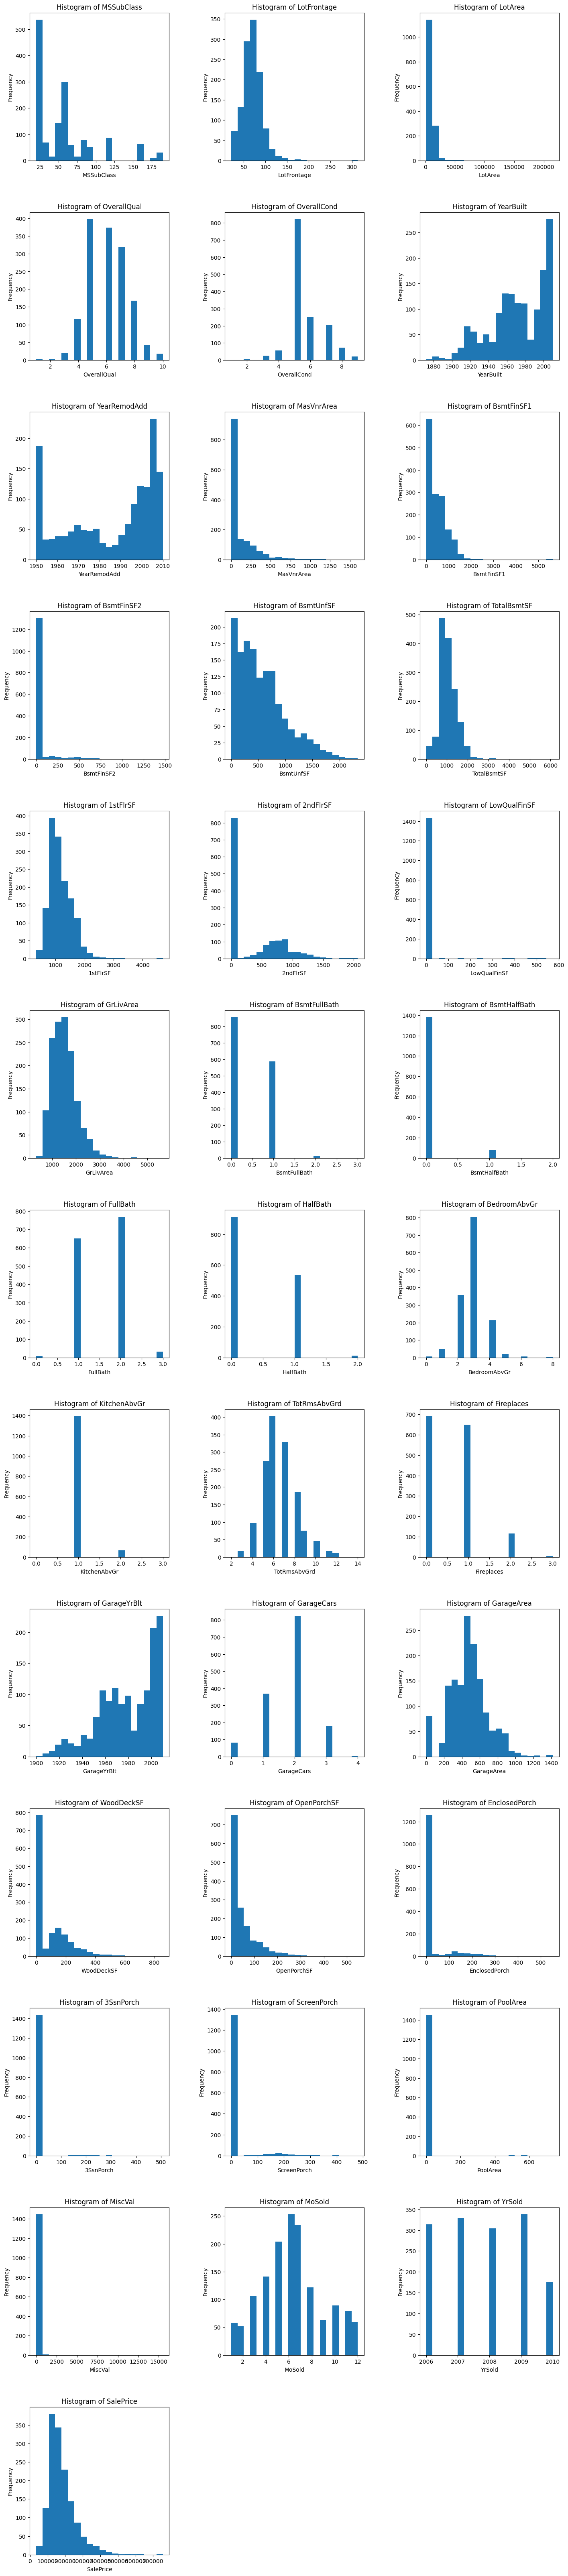

In [314]:
# Select numerical features for histogram plotting, excluding the 'ID' column
numerical_features = data.select_dtypes(include=np.number).drop(columns=['Id'], errors='ignore')
num_columns = 3  # Number of charts per row

# Calculate the total number of rows required
num_rows = int(np.ceil(len(numerical_features.columns) / num_columns))

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
fig.tight_layout(pad=5.0)

# Adjust spacing between charts
plt.subplots_adjust(hspace=0.35, wspace=0.4)  # Adjust these values as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each numerical feature
for idx, column in enumerate(numerical_features.columns):
    axes[idx].hist(data[column], bins=20)
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Histogram of {column}')

# Hide any remaining empty subplots
for i in range(len(numerical_features.columns), len(axes)):
    fig.delaxes(axes[i])

plt.show()

Numerical variables vs. Prices:

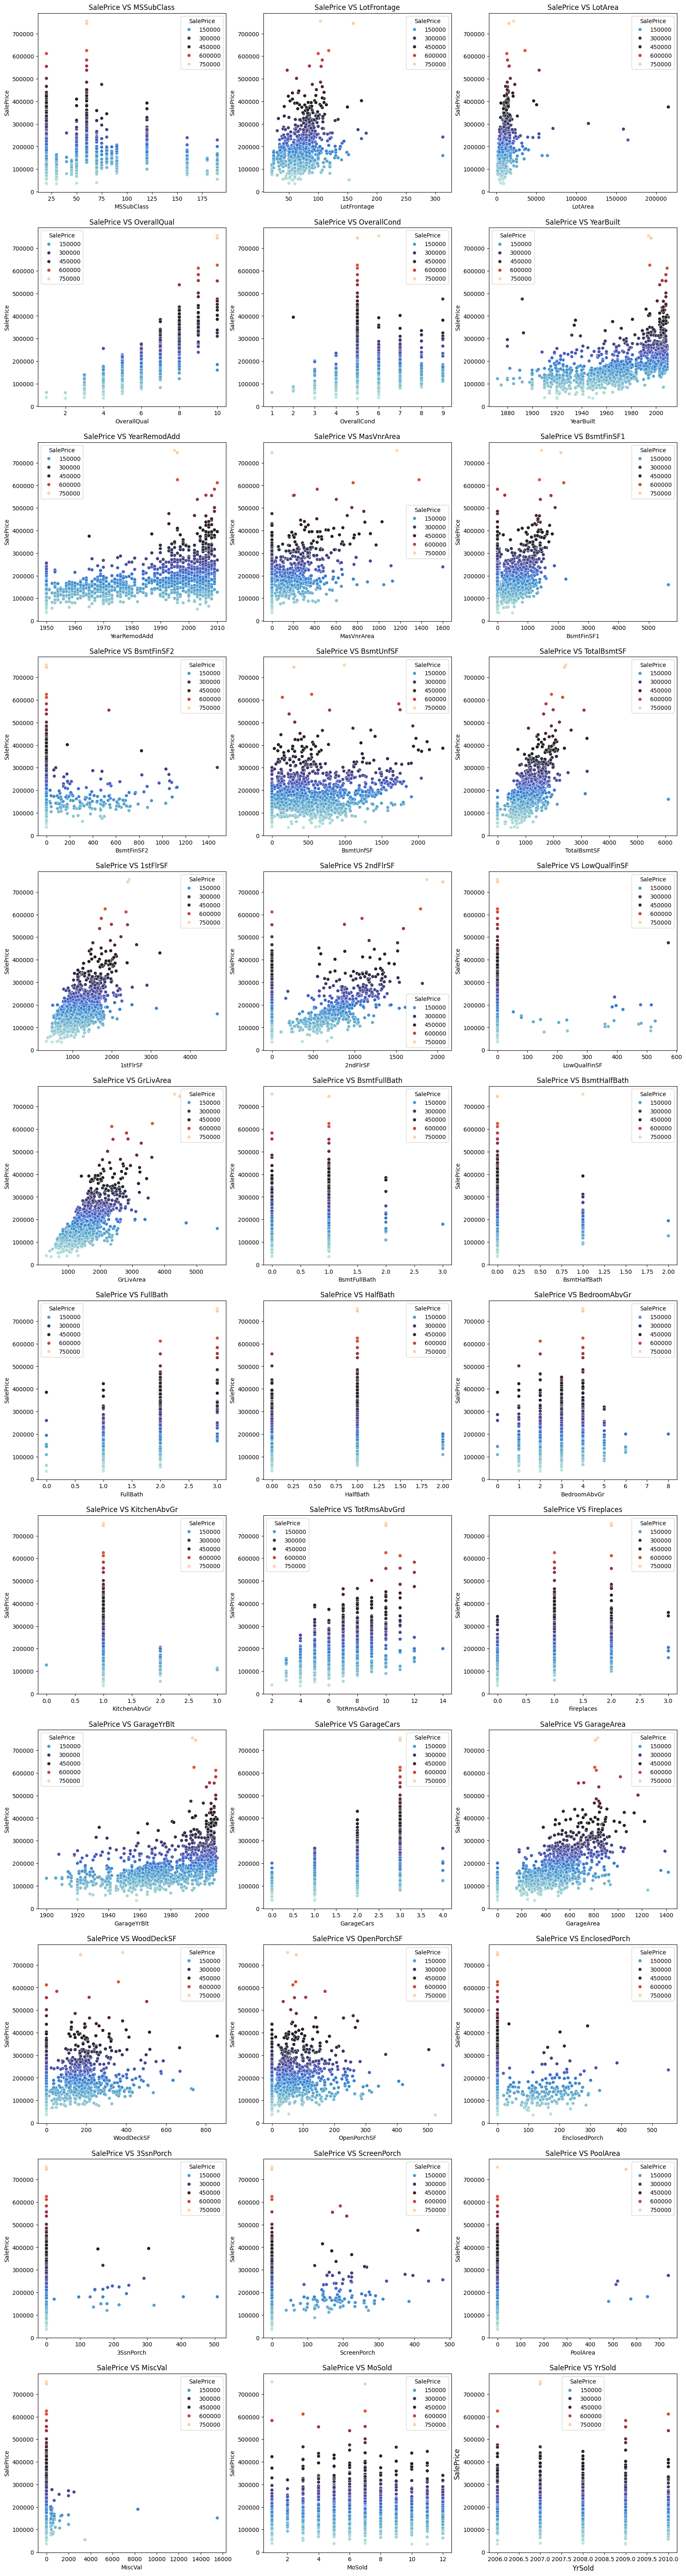

In [315]:
fig,axs= plt.subplots(12,3,figsize=(20,80))
for i,ax in zip(numerical_features.columns,axs.flatten()):
    # Reset index to avoid potential issues with duplicate indices
    sns.scatterplot(x=i, y='SalePrice', hue='SalePrice', data=numerical_features.reset_index(),ax=ax,palette='icefire')
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_title('SalePrice'+' VS '+str(i))

### Category

Distribution of categorical variables:

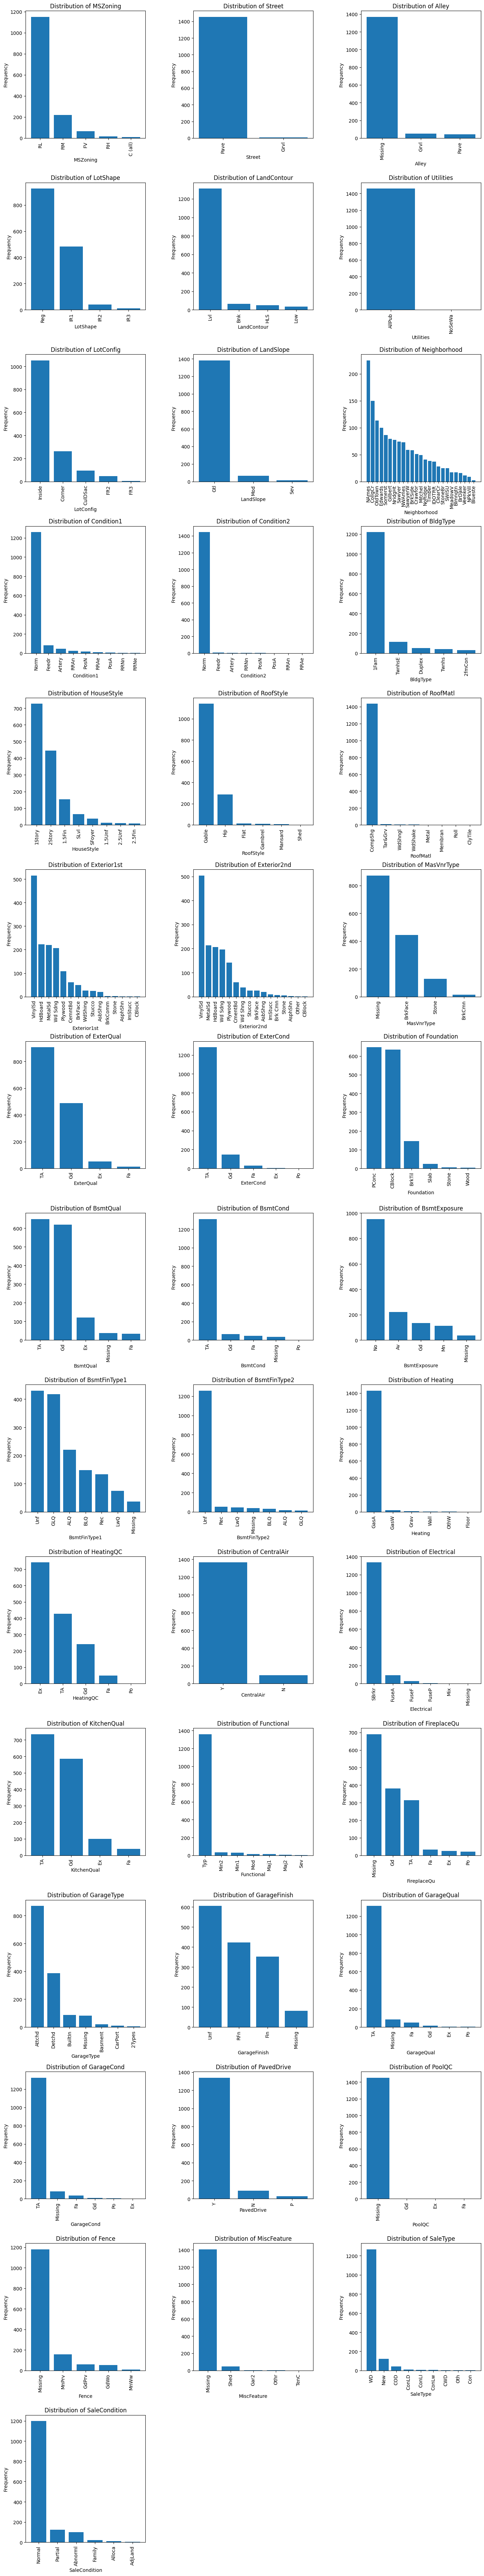

In [316]:
# Select categorical features for bar chart plotting
categorical_features = data.select_dtypes(exclude=np.number).fillna('Missing').astype(str)
num_columns = 3  # Number of charts per row

# Calculate the total number of rows required
num_rows = int(np.ceil(len(categorical_features.columns) / num_columns))

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
fig.tight_layout(pad=5.0)

# Adjust spacing between charts
plt.subplots_adjust(hspace=0.35, wspace=0.4)  # Adjust these values as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot bar charts for each categorical feature
for idx, column in enumerate(categorical_features.columns):
    value_counts = categorical_features[column].value_counts()  # Get frequency of each category
    axes[idx].bar(value_counts.index, value_counts.values)  # Create bar chart
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].tick_params(axis='x', rotation=90)  # Rotate x labels for better readability

# Hide any remaining empty subplots
for i in range(len(categorical_features.columns), len(axes)):
    fig.delaxes(axes[i])

plt.show()

Categorical variables vs. Prices:

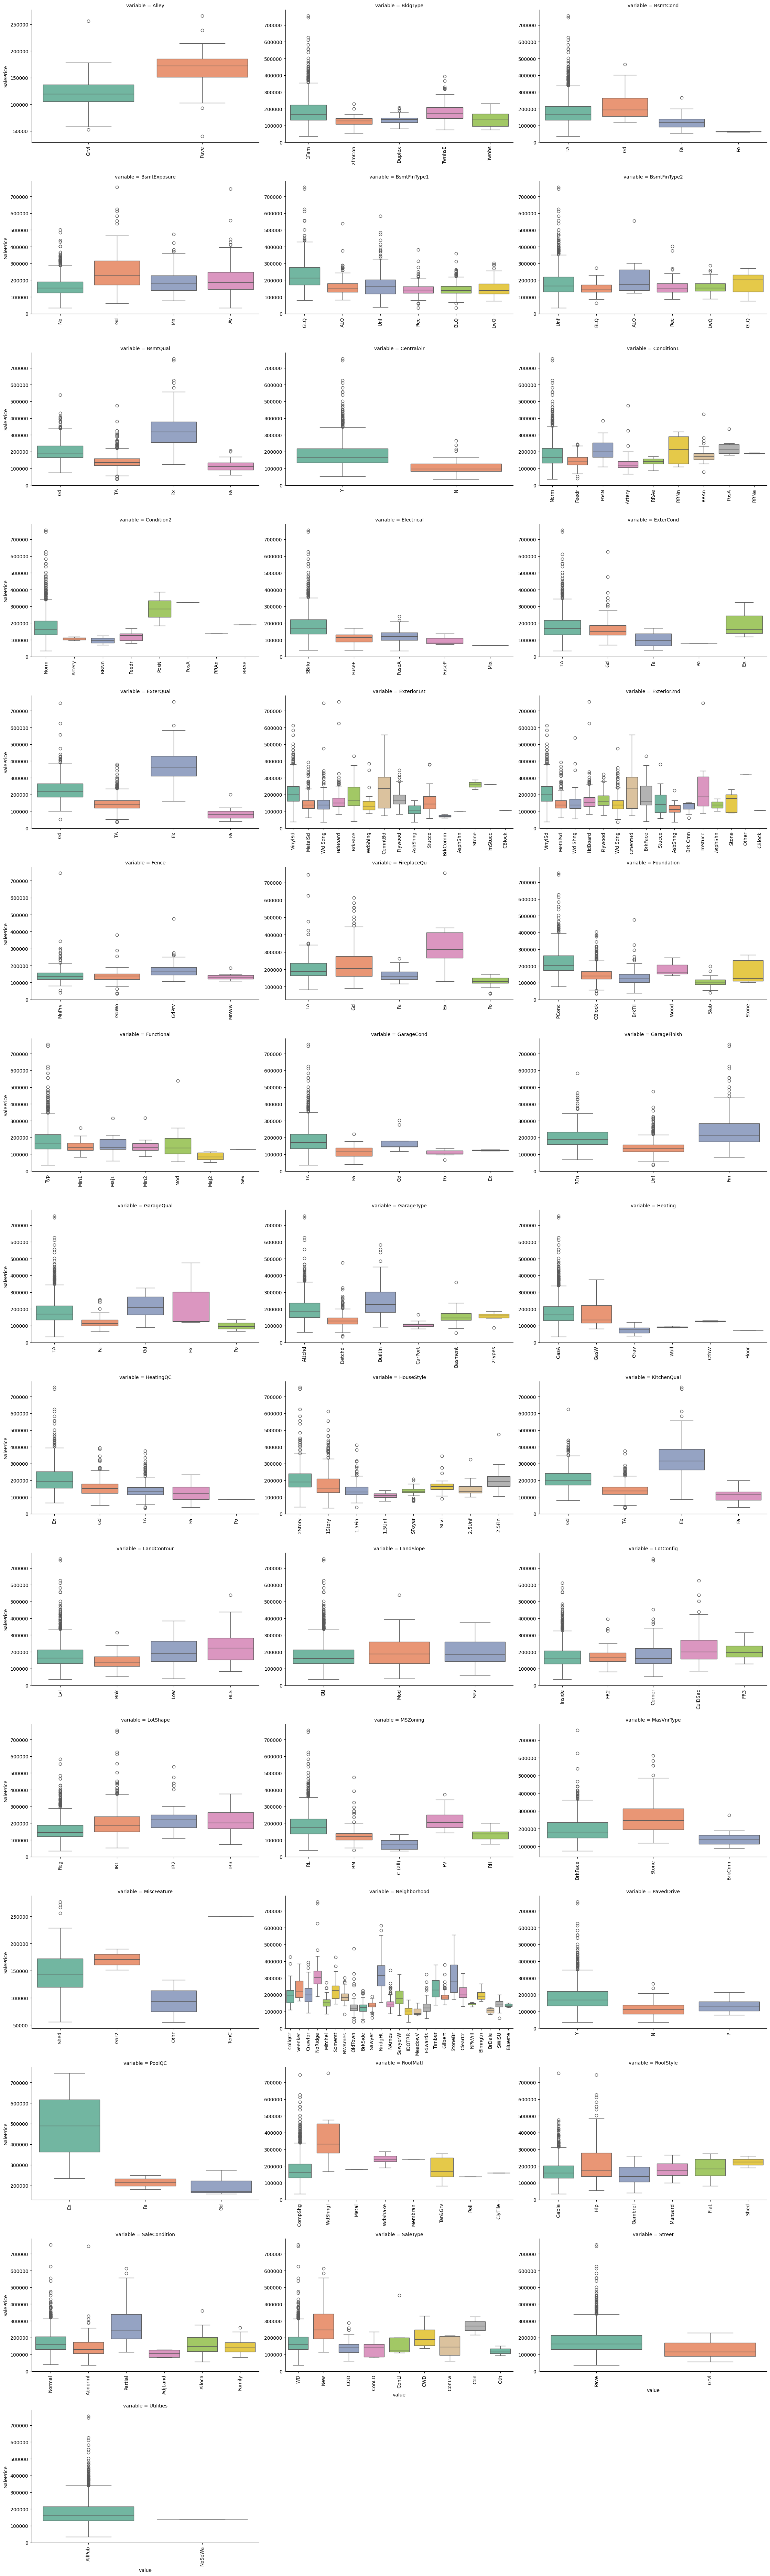

In [317]:
# Define the custom boxplot function
def facetgrid_boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y, palette="Set2")
    plt.xticks(rotation=90)

# Reshape data with pd.melt
f = pd.melt(data, id_vars=['SalePrice'], value_vars=sorted(data[categorical_features.columns]))

# Create the FacetGrid with height and aspect instead of size
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, height=5, aspect=1.5)

# Map the custom boxplot function to the grid
g = g.map(facetgrid_boxplot, "value", "SalePrice")

# Show the plot
plt.show()

### Date

In [318]:
# numeric
print('Number of numerical columns:', len(numerical_features.columns))
print(numerical_features.columns)
print('--------------------------------------------------------')

# category
print('Number of categorical columns:', len(categorical_features.columns))
print(categorical_features.columns)
print('--------------------------------------------------------')

Number of numerical columns: 37
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
--------------------------------------------------------
Number of categorical columns: 43
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCo

Note: Some numerical variabes are date columns

In [319]:
# make a list of date time columns
date_col = []
for col in numerical_features:
  if 'Yr' in col or 'Year' in col or 'Mo' in col:
    date_col.append(col)
print('Number of date time columns:', len(date_col))
print('------------------------------------------')
data[date_col].head()

Number of date time columns: 5
------------------------------------------


YearBuilt  YearRemodAdd  GarageYrBlt  MoSold  YrSold
0       2003          2003       2003.0       2    2008
1       1976          1976       1976.0       5    2007
2       2001          2002       2001.0       9    2008
3       1915          1970       1998.0       2    2006
4       2000          2000       2000.0      12    2008

In [320]:
# show nunique and those unique of columns in date_col
for col in date_col:
  print(f"Column '{col}' has {data[col].nunique()} unique values: {data[col].unique()}")
  print('-----------------------------------------------------------------------------')

Column 'YearBuilt' has 112 unique values: [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]
-----------------------------------------------------------------------------
Column 'YearRemodAdd' has 61 unique values: [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 198

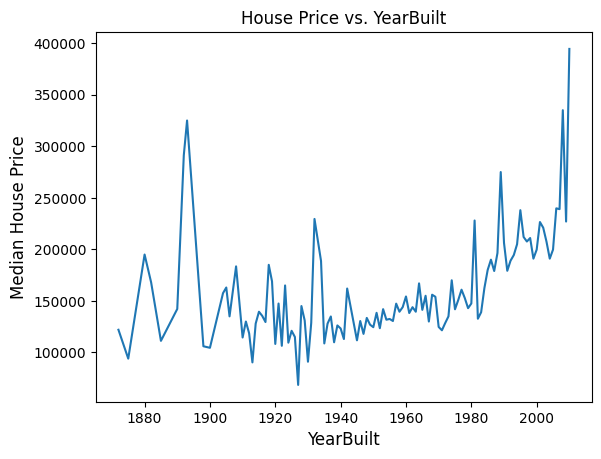

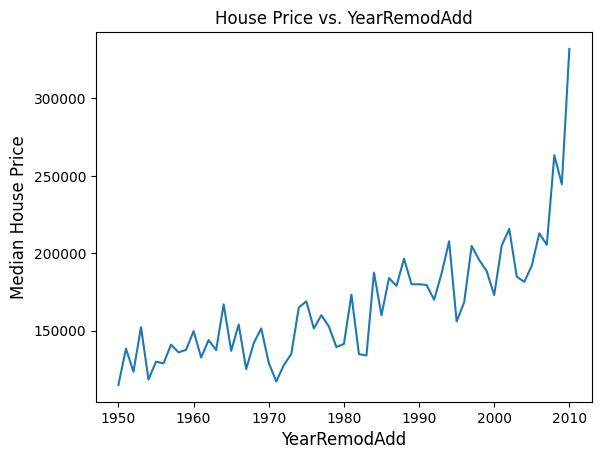

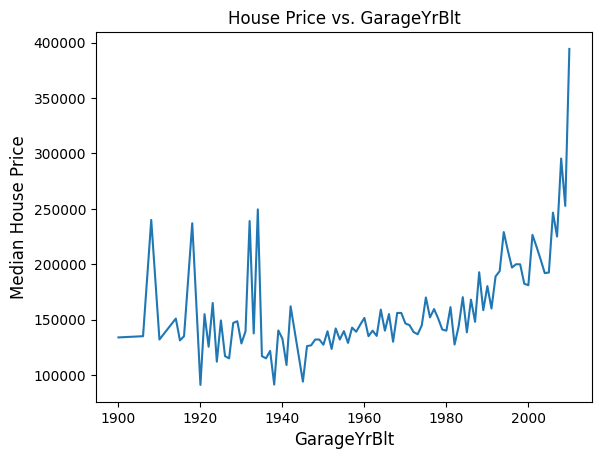

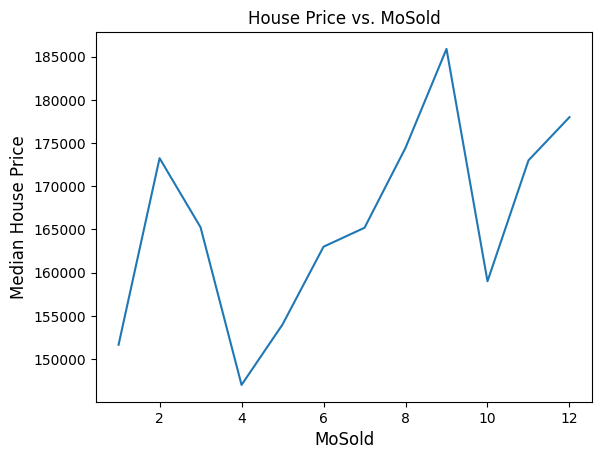

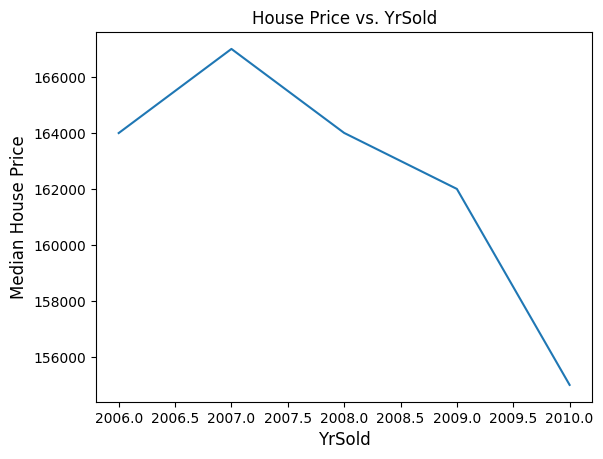

In [321]:
# plot line chart show relationship between SalePrice vs date columns
for col in date_col:
  data.groupby(col)['SalePrice'].median().plot()
  plt.xlabel(col,fontsize=12)
  plt.ylabel('Median House Price',fontsize=12)
  plt.title("House Price vs. "+str(col))
  plt.show()

- YearBuilt: year the house was built
- YearRemodAdd: year the house was remodeled
- GarageYrBlt: year the garage of the house was built
- MoSold: month the house was sold
- YrSold: year the house was sold

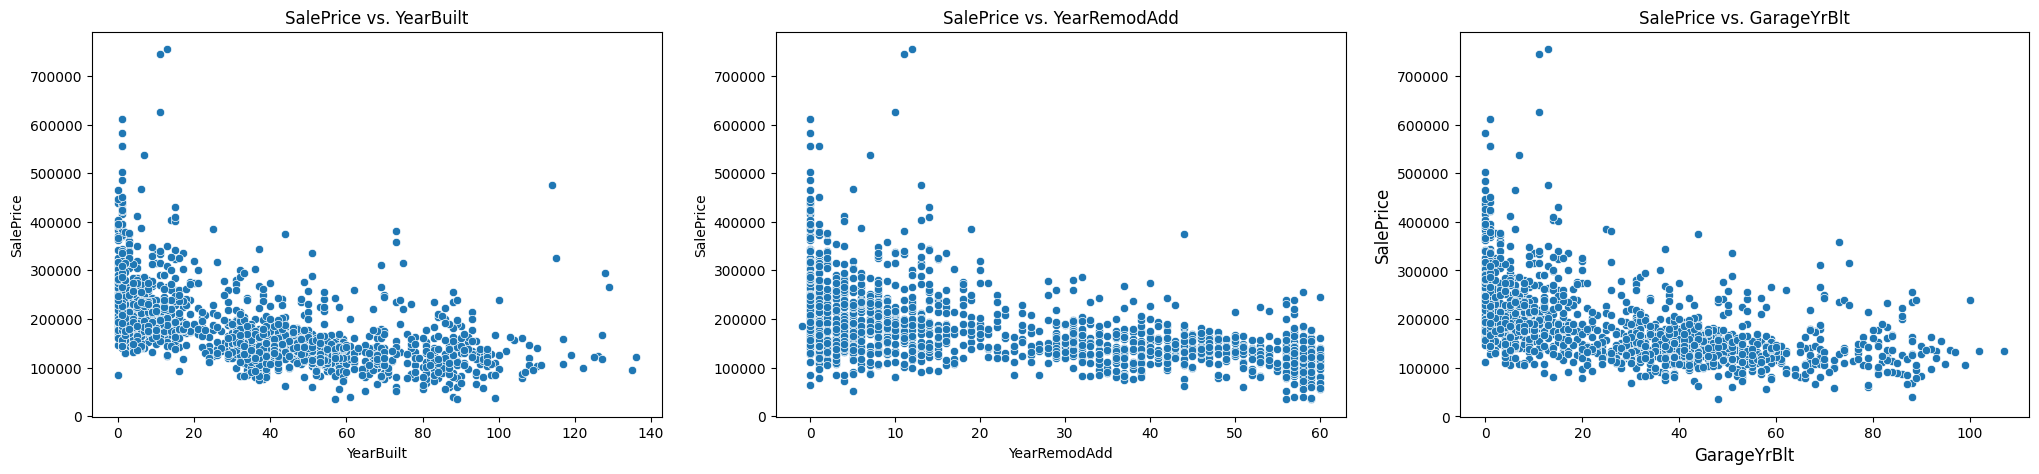

In [322]:
# plot line chart show relationship between SalePrice vs date columns
fig,axs= plt.subplots(1,3,figsize=(25,5),squeeze=True)
for col,ax in zip(date_col,axs.flatten()):
    if col not in ['YrSold', 'MoSold']:
        dt=data.copy()
        # calculate the mean SalePrice of the YrSold minus each columns in date_col
        dt[col] = dt['YrSold'] - data[col]
        # Reset the index of dt before plotting to avoid duplicate index issues
        dt = dt.reset_index()
        sns.scatterplot(x=dt[col], y=dt['SalePrice'], data=dt, ax=ax, palette='icefire')
        plt.xlabel(col,fontsize=12)
        plt.ylabel('SalePrice',fontsize=12)
        ax.set_title('SalePrice'+' vs. '+str(col))

In [323]:
# change data type of YrSold
data['YrSold'] = data['YrSold'].astype('int')

Note: The more ages the houses get, the prices are getting lower

Split numerical variables into discrete and continous ones:

In [324]:
# discrete
discrete_features = [feature for feature in numerical_features if len(data[feature].unique())<25 and feature not in date_col + ['Id']]
print('Number of discrete numerical columns:', len(discrete_features))
print(discrete_features)
print('--------------------------------------------------------')

# continous
continous_features = [feature for feature in numerical_features if feature not in discrete_features + date_col + ['Id']]
print('Number of continous numerical columns:', len(continous_features))
print(continous_features)

Number of discrete numerical columns: 16
['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal']
--------------------------------------------------------
Number of continous numerical columns: 16
['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'SalePrice']


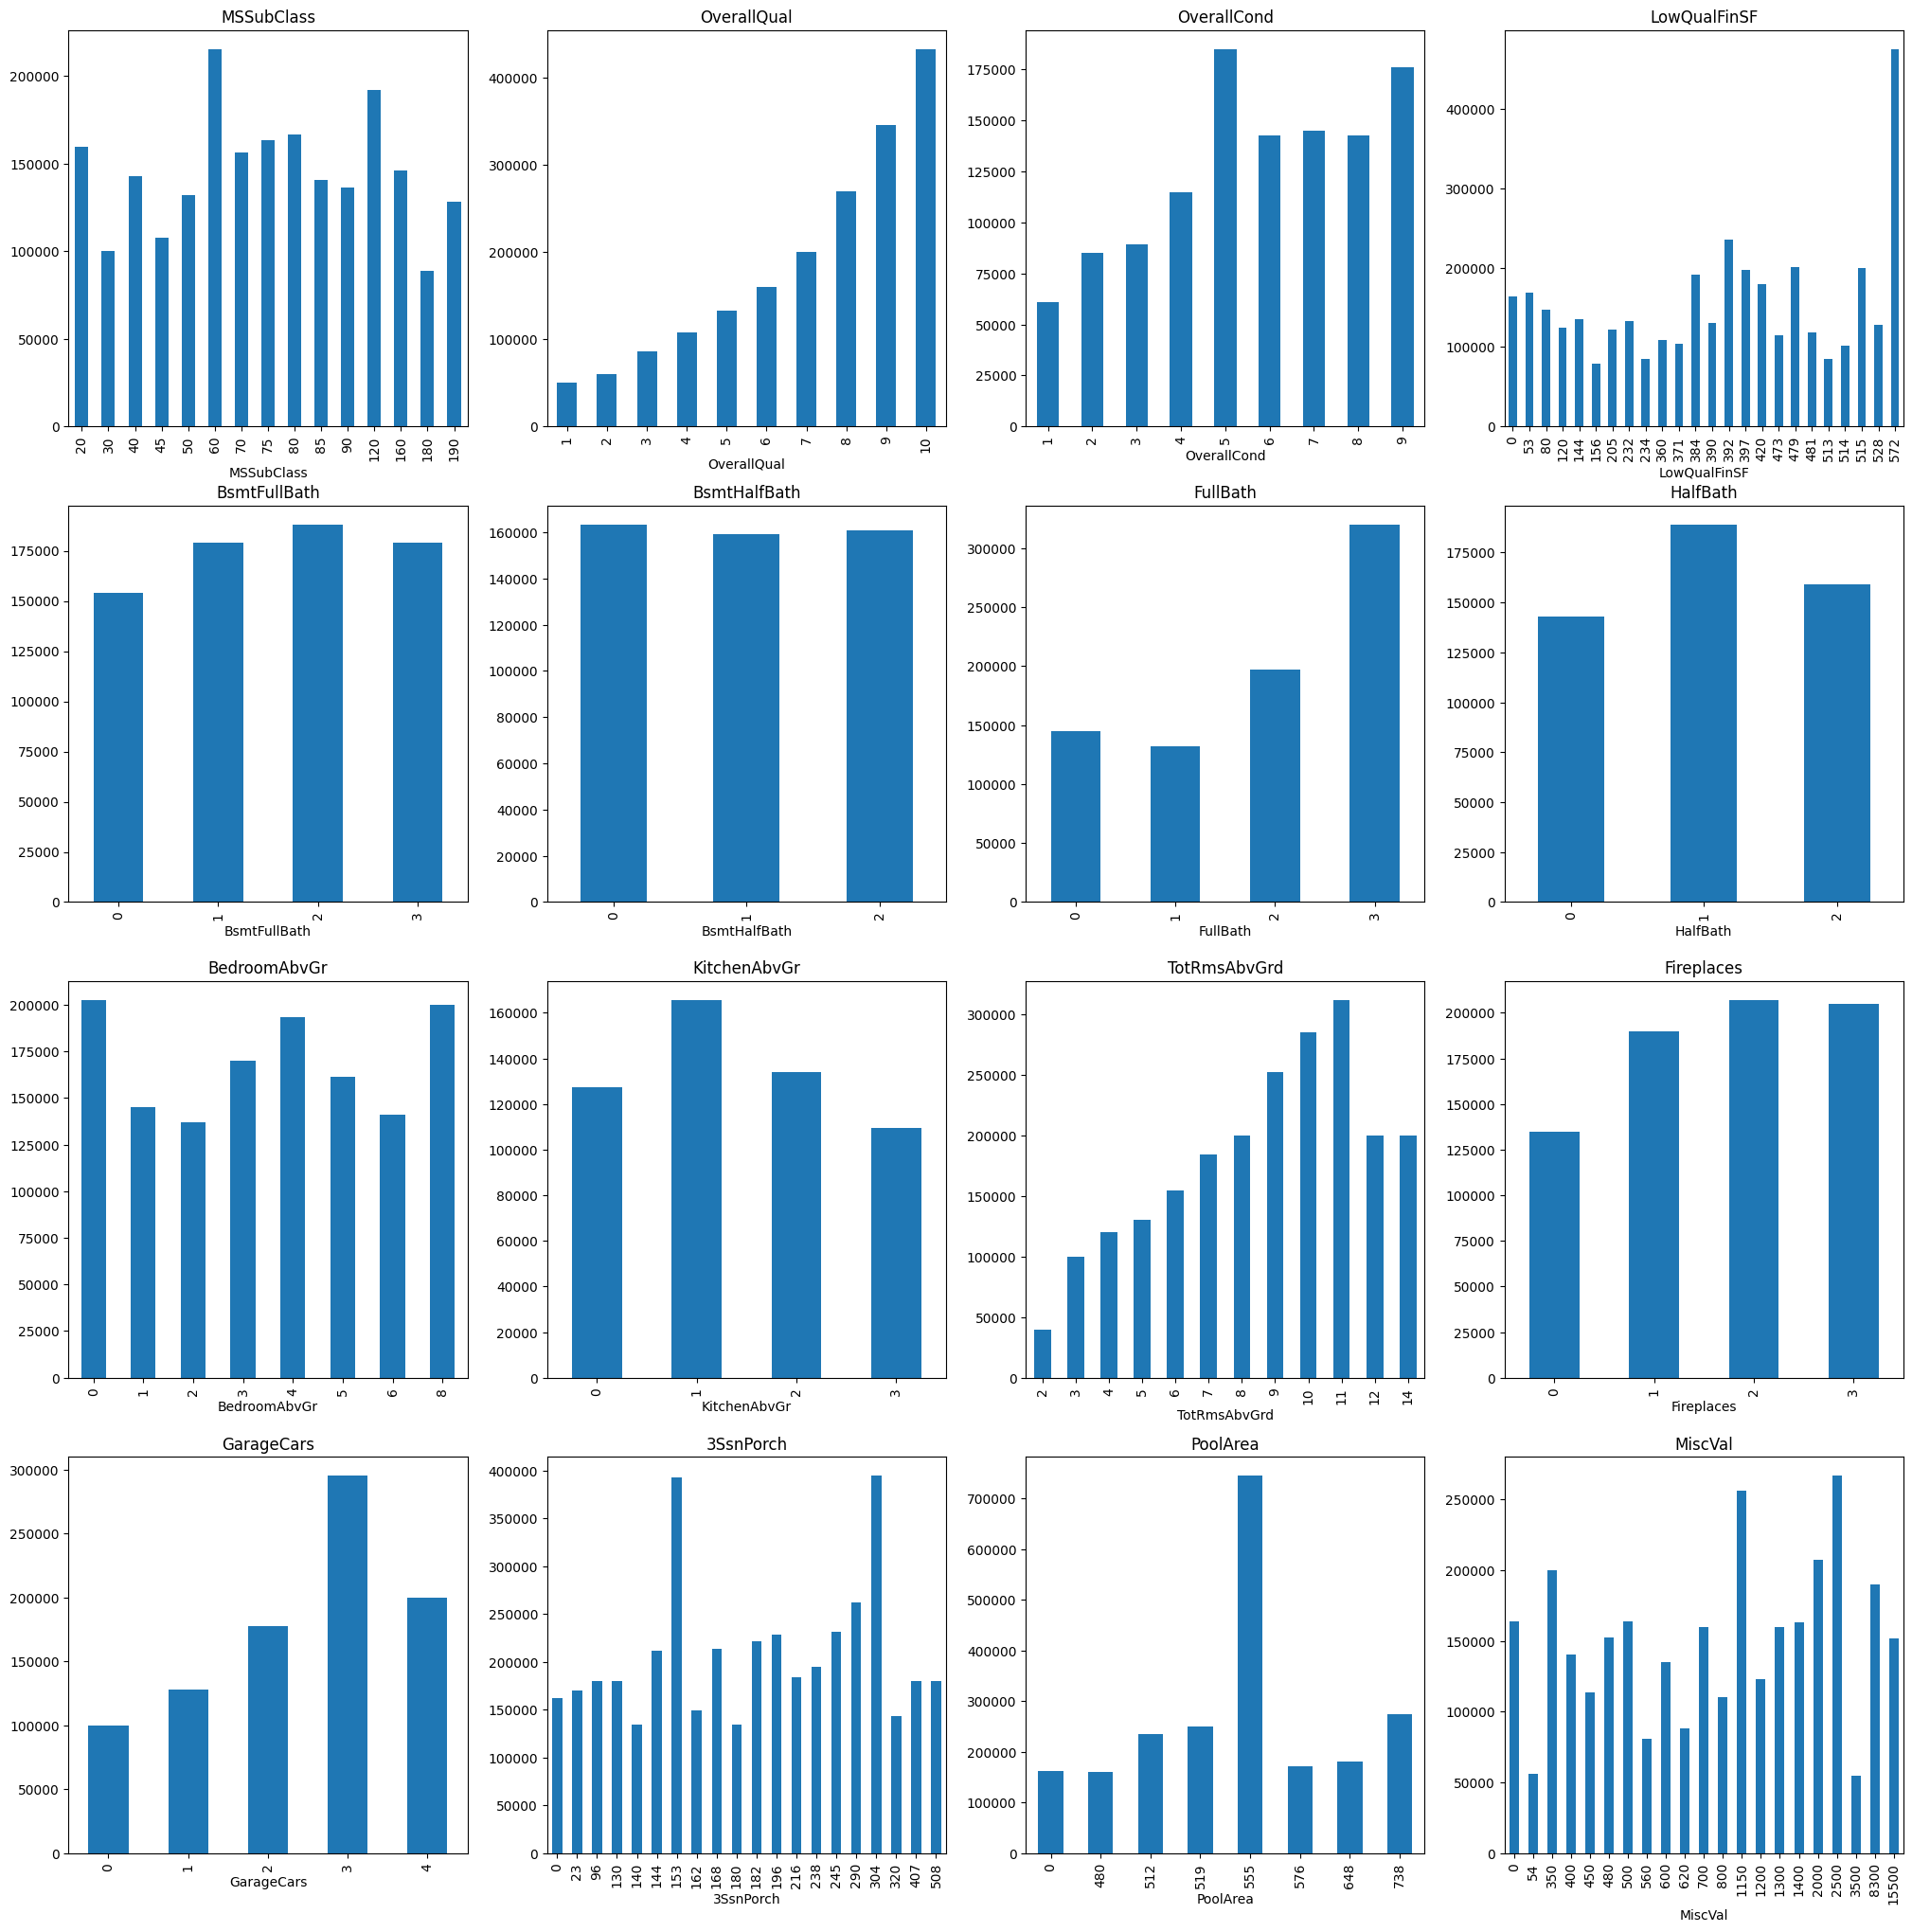

In [325]:
# plot histogram of discrete features
fig,axs= plt.subplots(4,4,figsize=(25,25))
for i,ax in zip(discrete_features,axs.flatten()):
    data.groupby(i)['SalePrice'].median().plot.bar(ax=ax)
    ax.set_title(i)

# Hide any remaining empty subplots
for i in range(len(discrete_features), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

plt.show()

Note: MSSubClass identifies the type of dwelling involved in the sale => not actually a numerical variable

In [326]:
# change data type of MSSubclass
data['MSSubClass'] = data['MSSubClass'].astype('object')

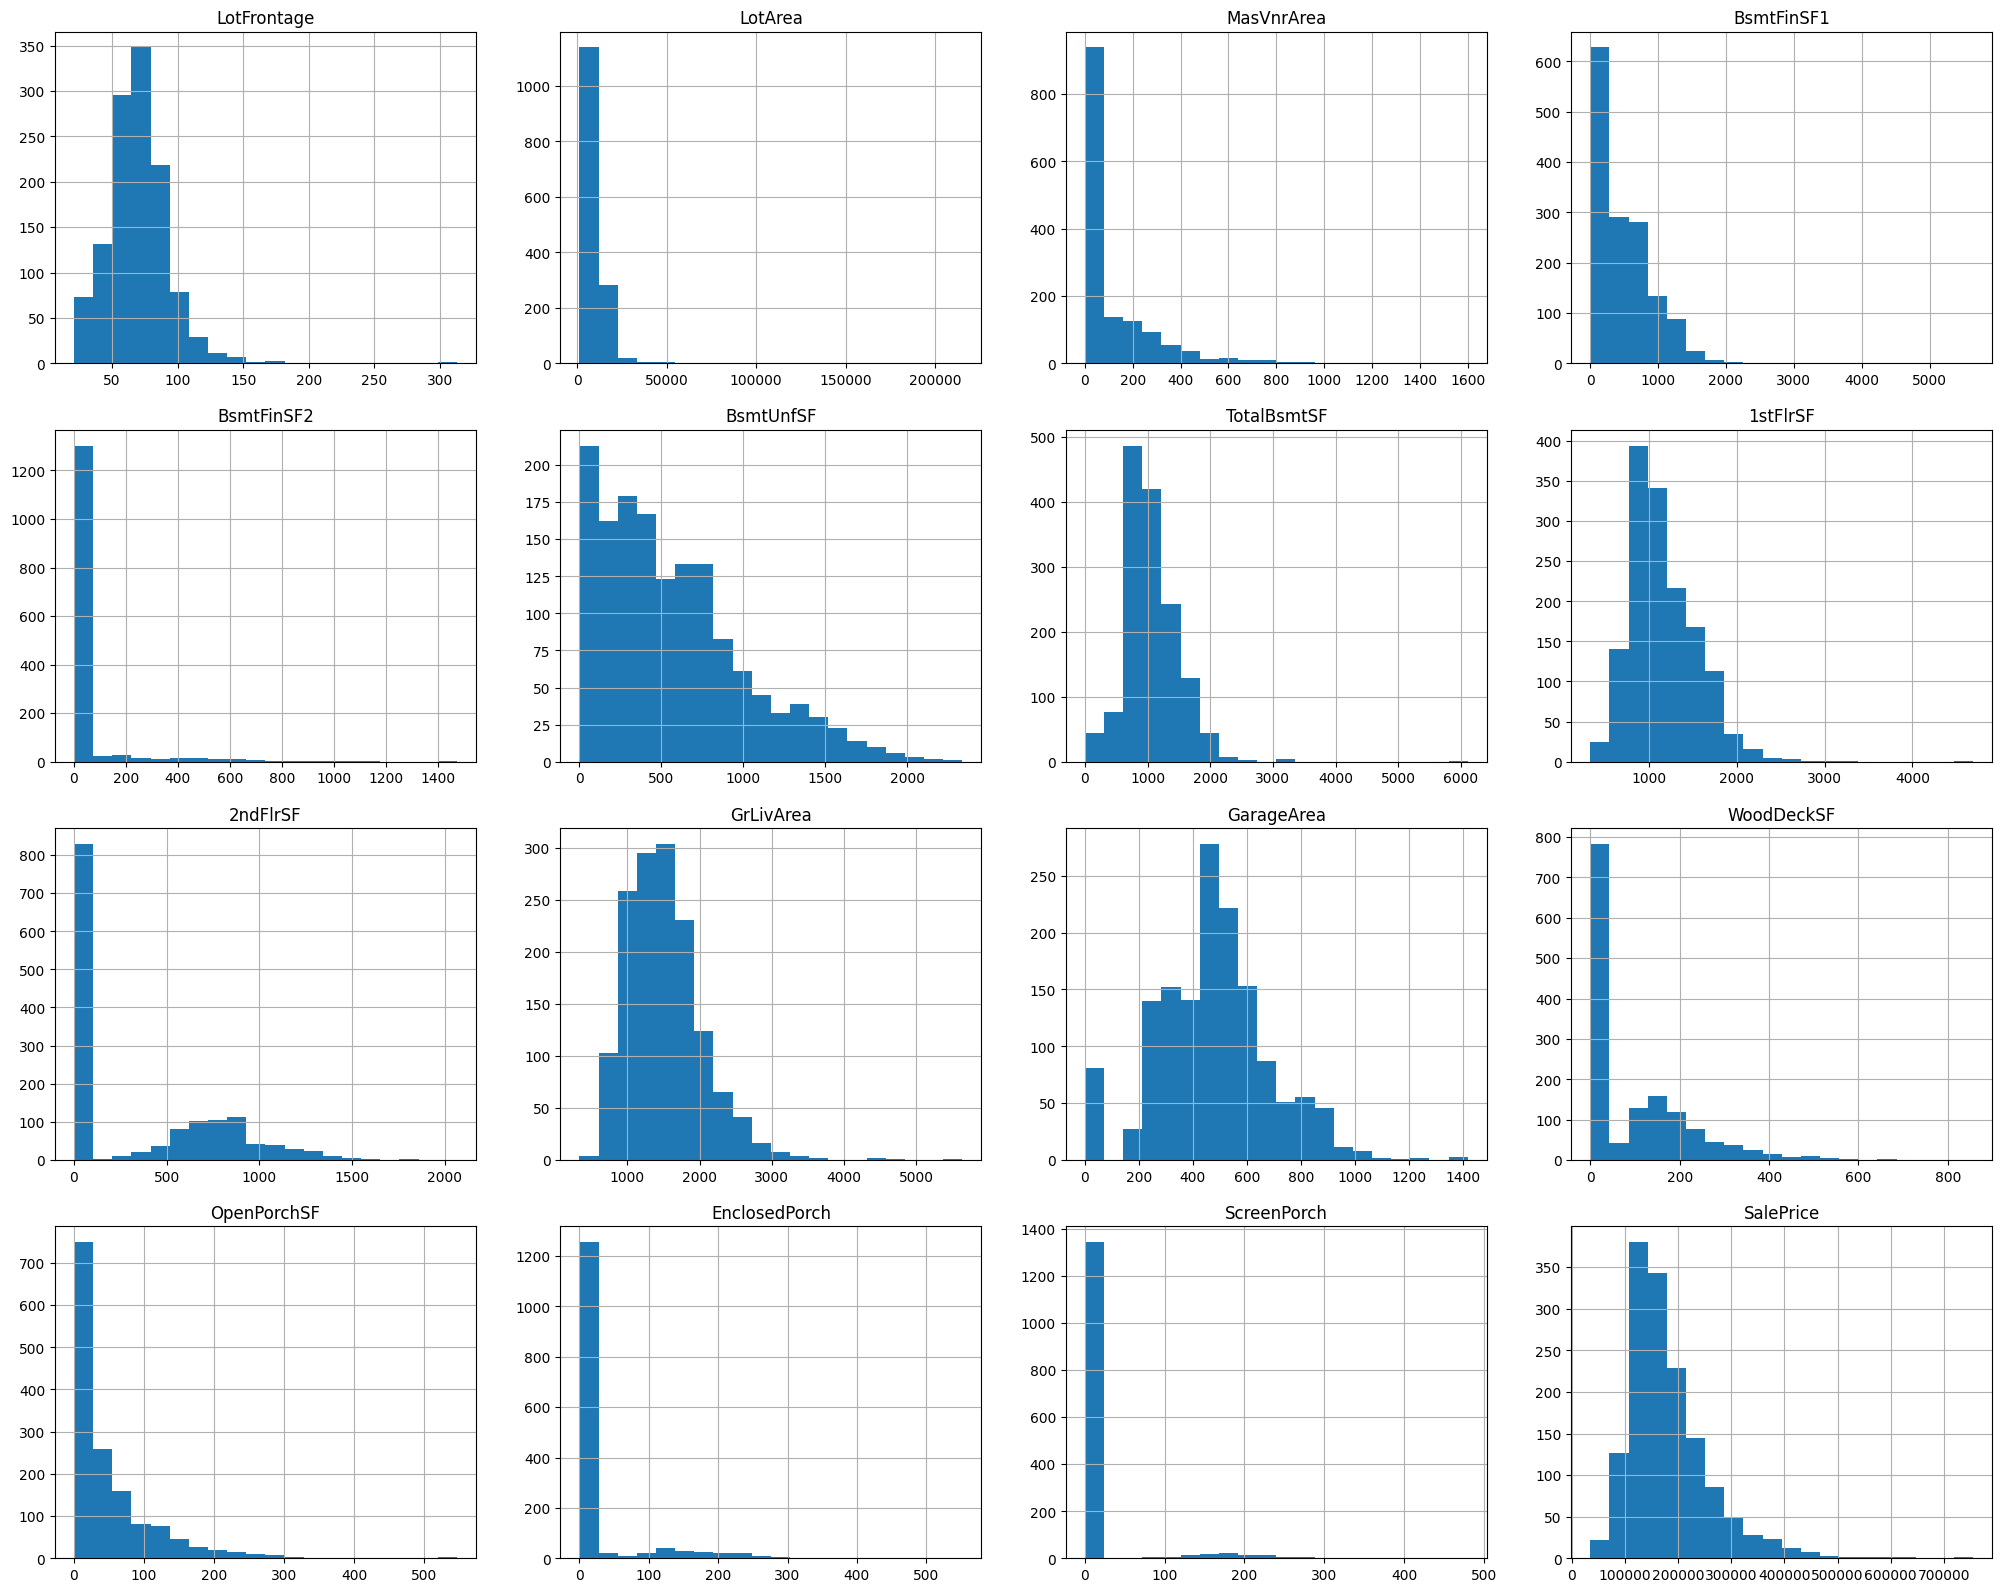

In [327]:
# plot histogram of continous features
fig,axs= plt.subplots(5,4,figsize=(25,25))
for i,ax in zip(continous_features,axs.flatten()):
  data[i].hist(bins=20,ax=ax)
  ax.set_title(i)

# Hide any remaining empty subplots
for i in range(len(continous_features), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

plt.show()

Note: Most of continous features are right-skewed => log transformation

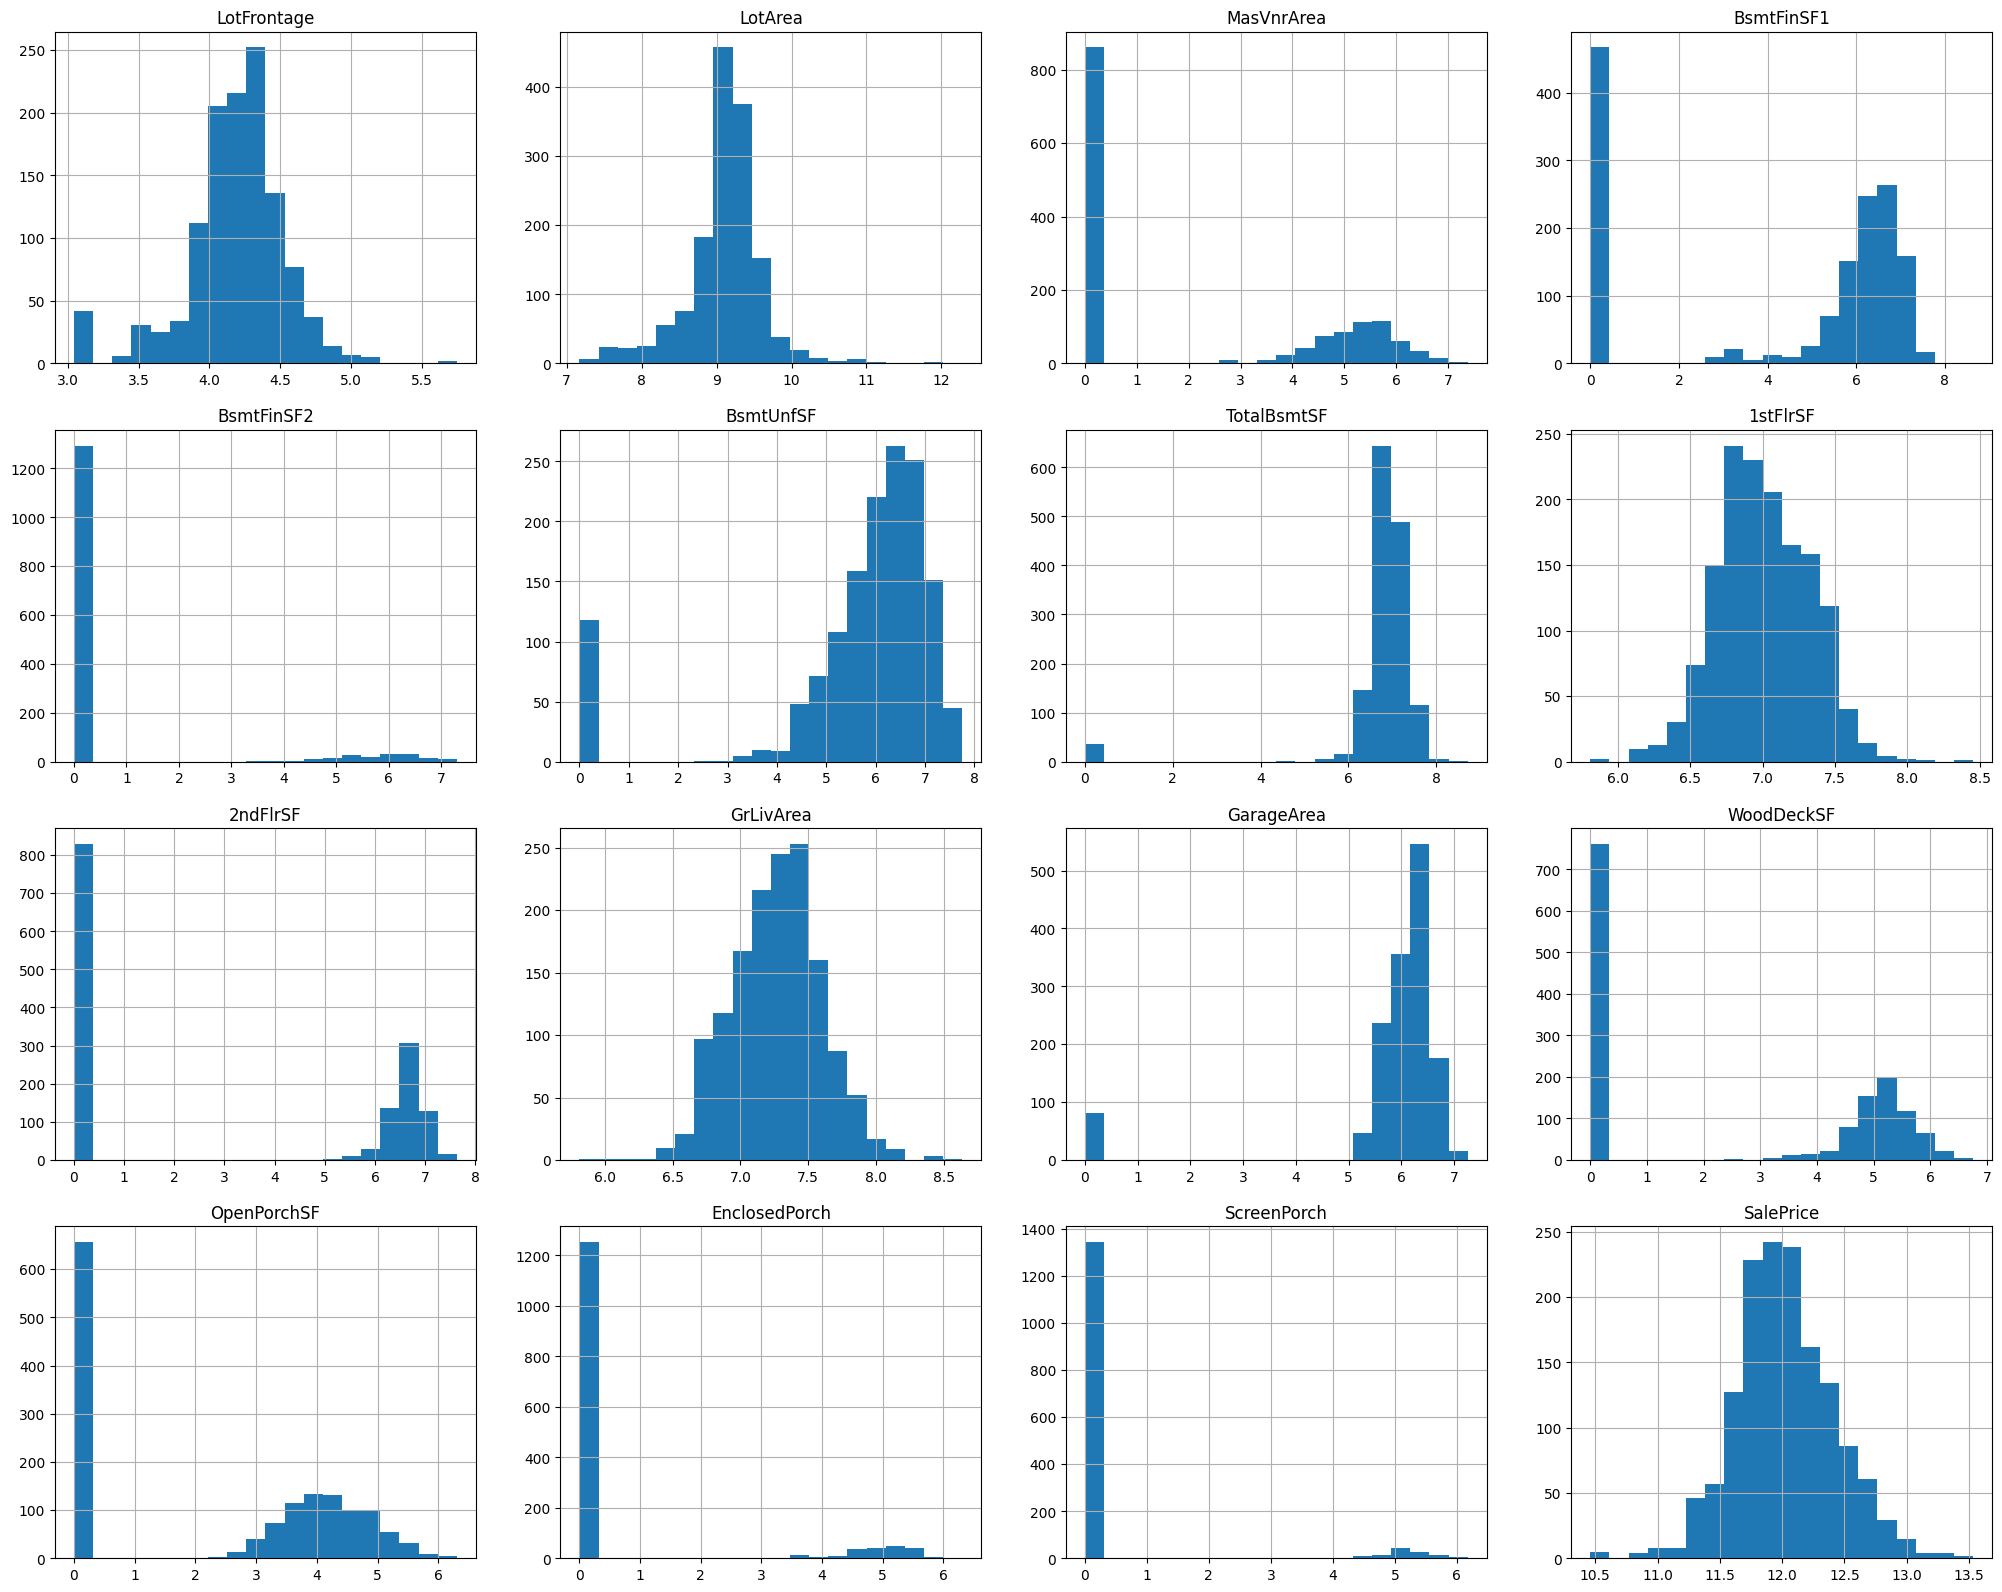

In [328]:
# plot histogram of continous features using log transformation
fig,axs= plt.subplots(5,4,figsize=(25,25))
for i,ax in zip(continous_features,axs.flatten()):
  dt = data.copy()
  if 0 in dt[i].unique():
    dt[i] = np.log(dt[i] + 1)
  else:
    dt[i] = np.log(dt[i])
    # dt['SalePrice'] = np.log(dt['SalePrice'])
  dt[i].hist(bins=20,ax=ax)
  ax.set_title(i)

# Hide any remaining empty subplots
for i in range(len(continous_features), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

plt.show()

Note: Do two scalers to compare performance

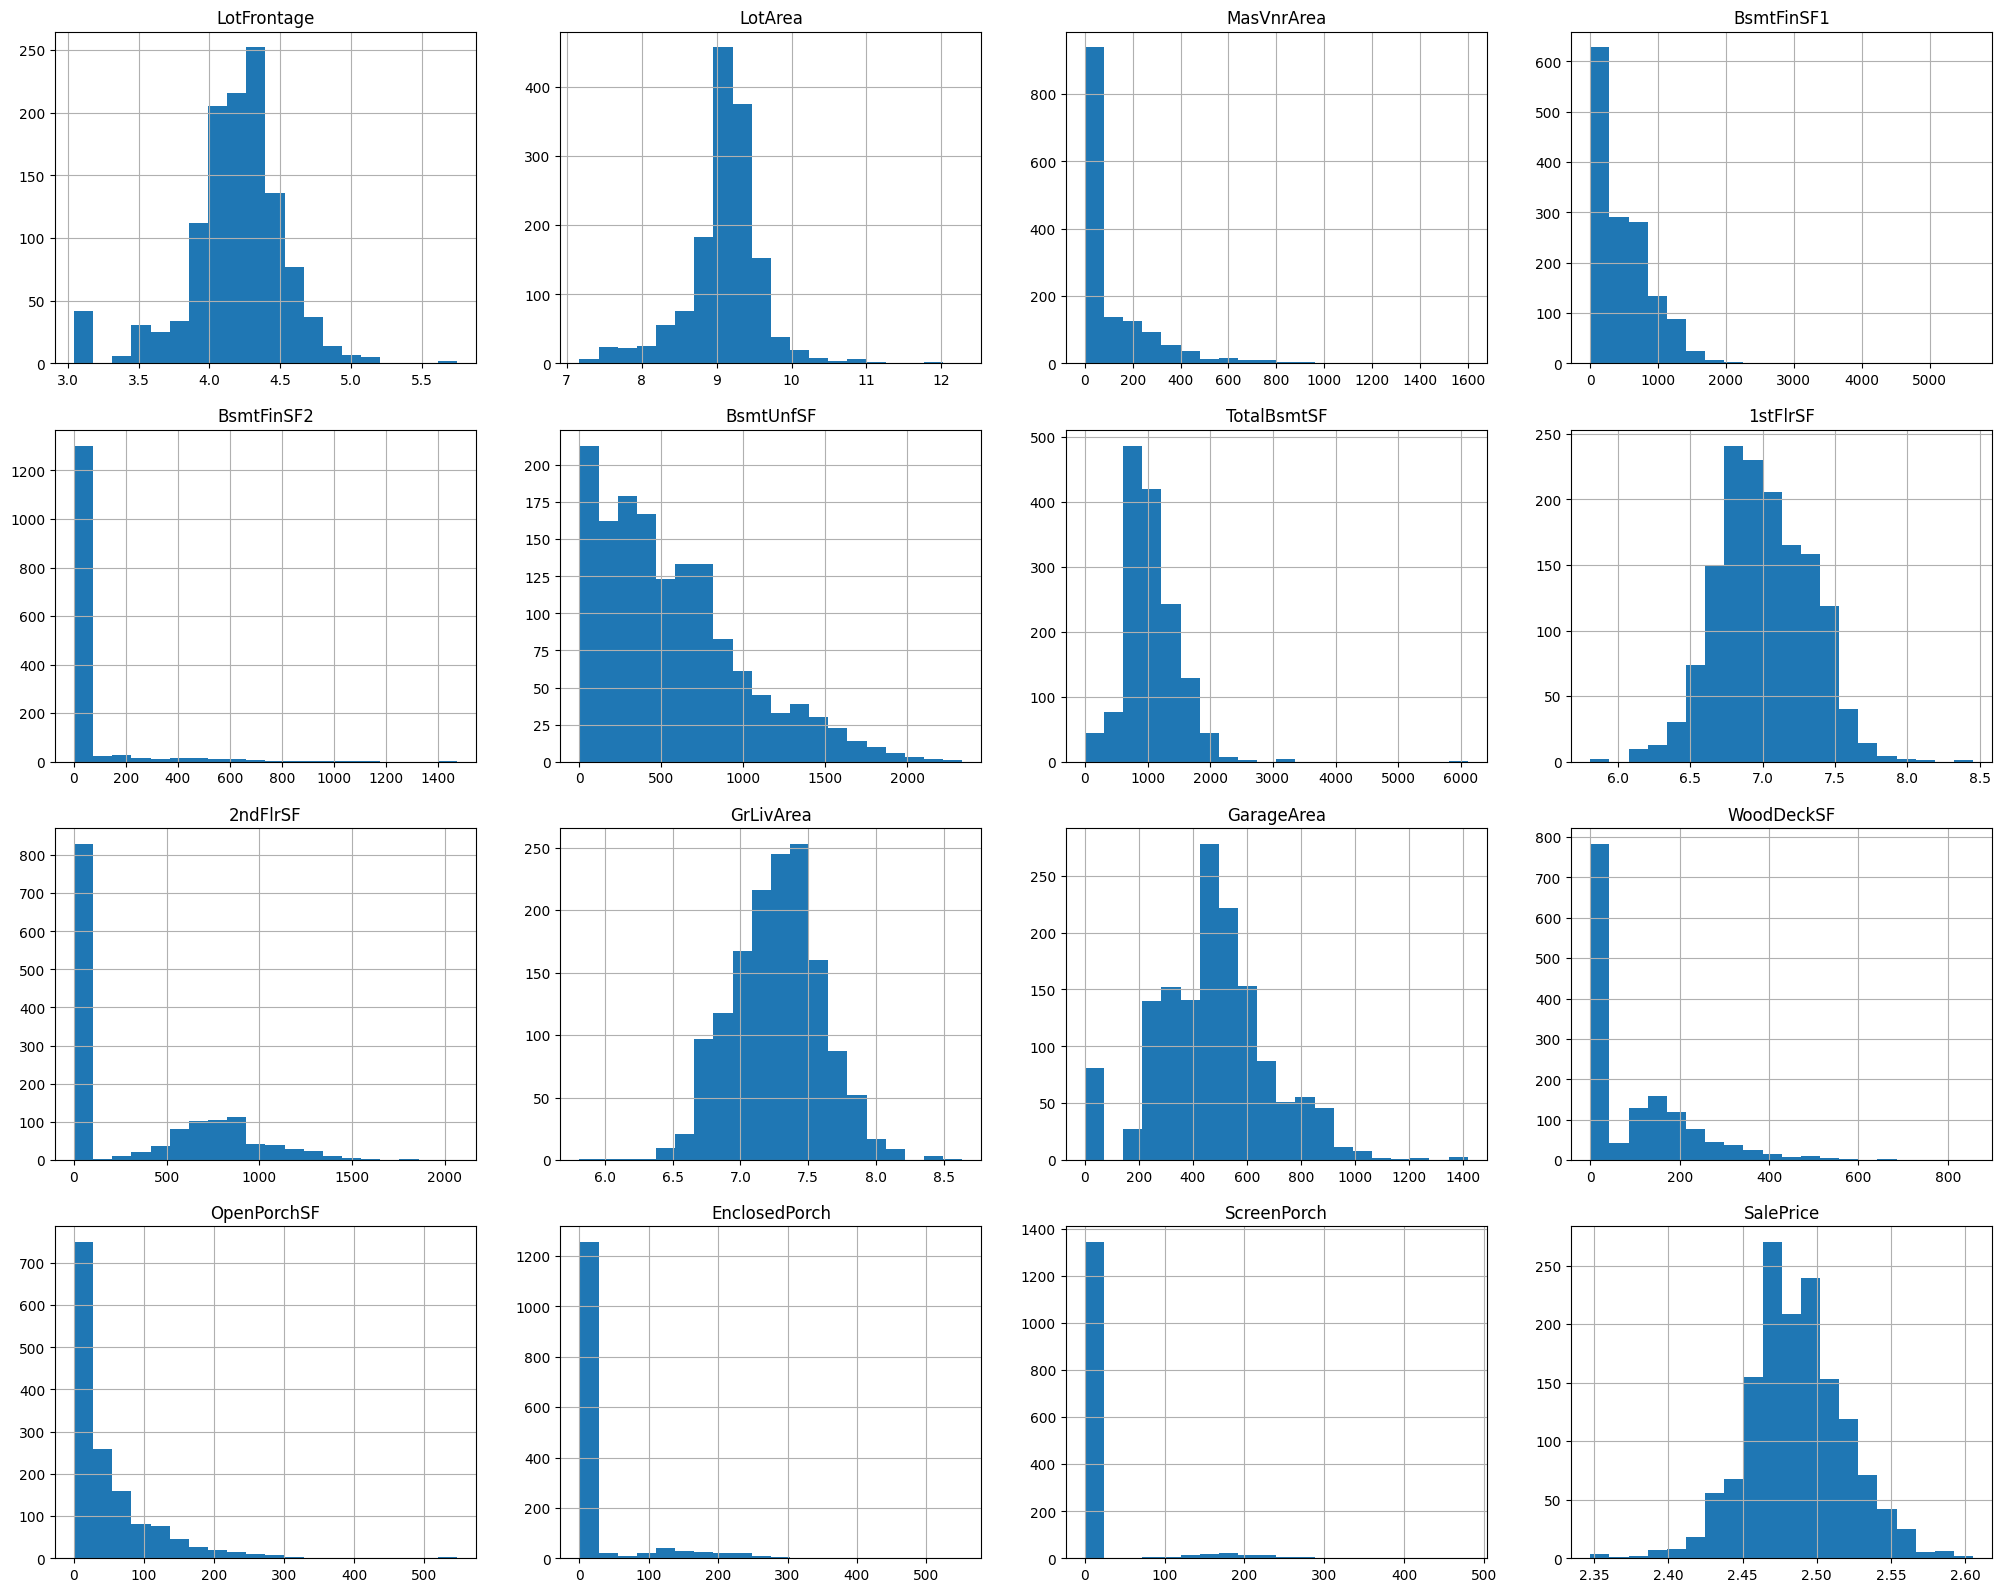

In [329]:
# plot histogram of continous features using log transformation
fig,axs= plt.subplots(5,4,figsize=(25,25))
for i,ax in zip(continous_features,axs.flatten()):
  dt = data.copy()
  if 0 in dt[i].unique():
    pass
  else:
    dt[i] = np.log(dt[i])
    dt['SalePrice'] = np.log(dt['SalePrice'])
  dt[i].hist(bins=20,ax=ax)
  ax.set_title(i)

# Hide any remaining empty subplots
for i in range(len(continous_features), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

plt.show()

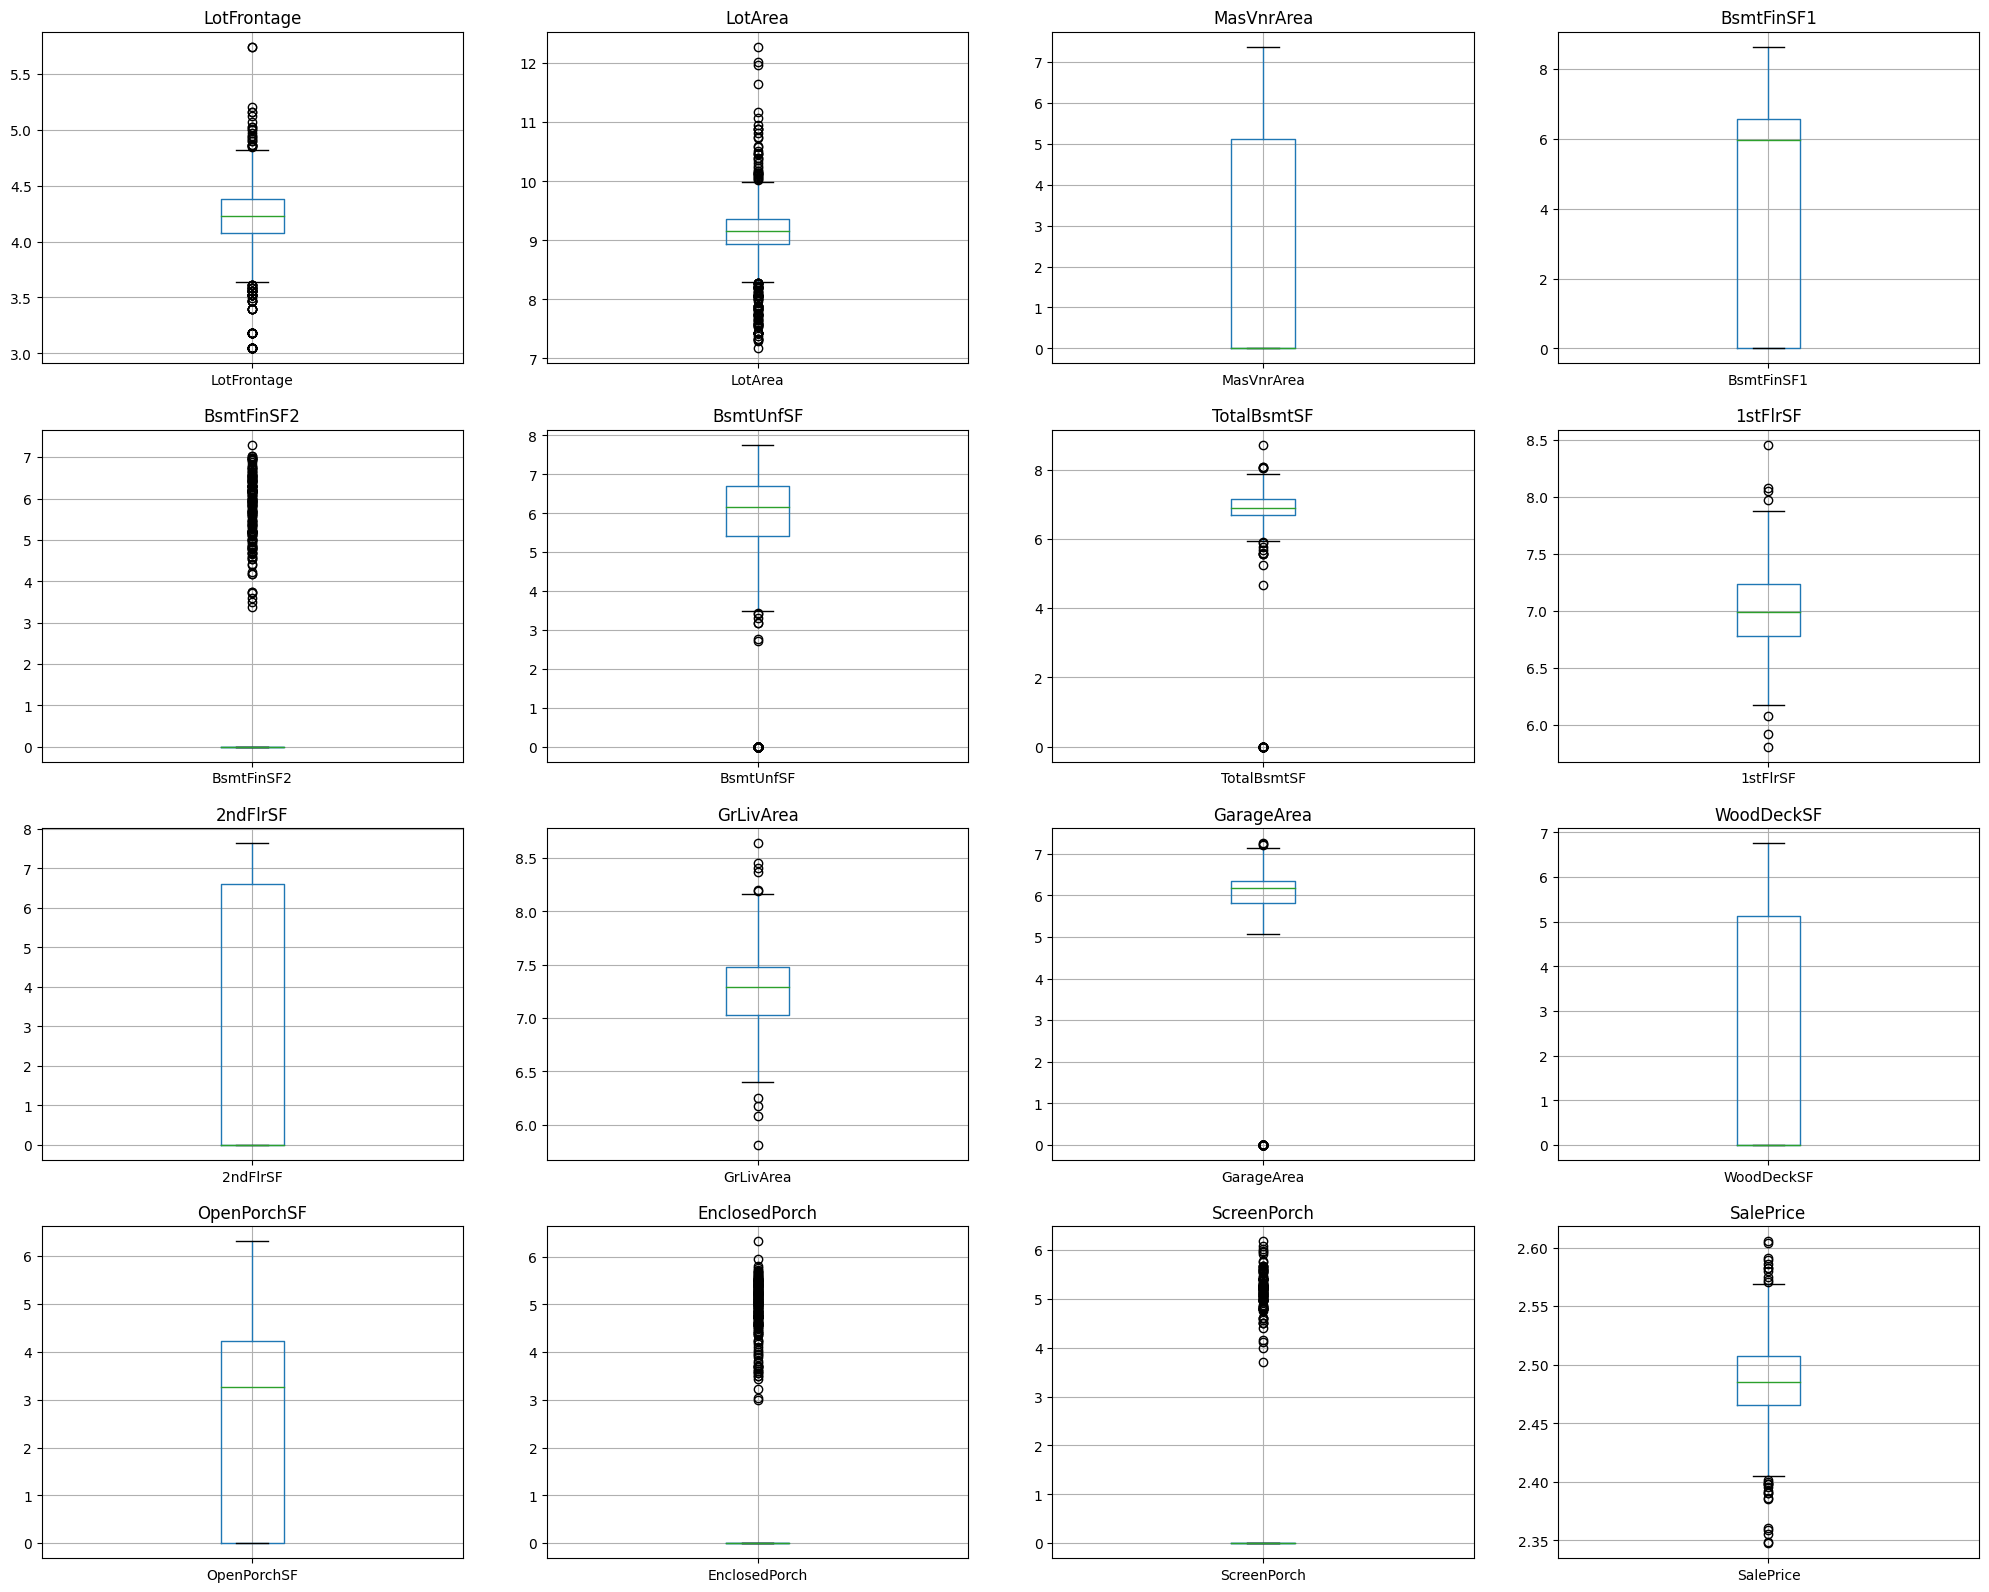

In [330]:
# plot boxplot of continous features using log transformation
fig,axs= plt.subplots(5,4,figsize=(25,25))
for i,ax in zip(continous_features,axs.flatten()):
  dt = data.copy()
  if 0 in dt[i].unique():
    dt[i] = np.log(dt[i] + 1)
  else:
    dt[i] = np.log(dt[i])
    dt['SalePrice'] = np.log(dt['SalePrice'])
  dt.boxplot(column=i,ax=ax)
  ax.set_title(i)

# Hide any remaining empty subplots
for i in range(len(continous_features), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

plt.show()

Note: There're outliers needed to be handled

Check correlation between variables:

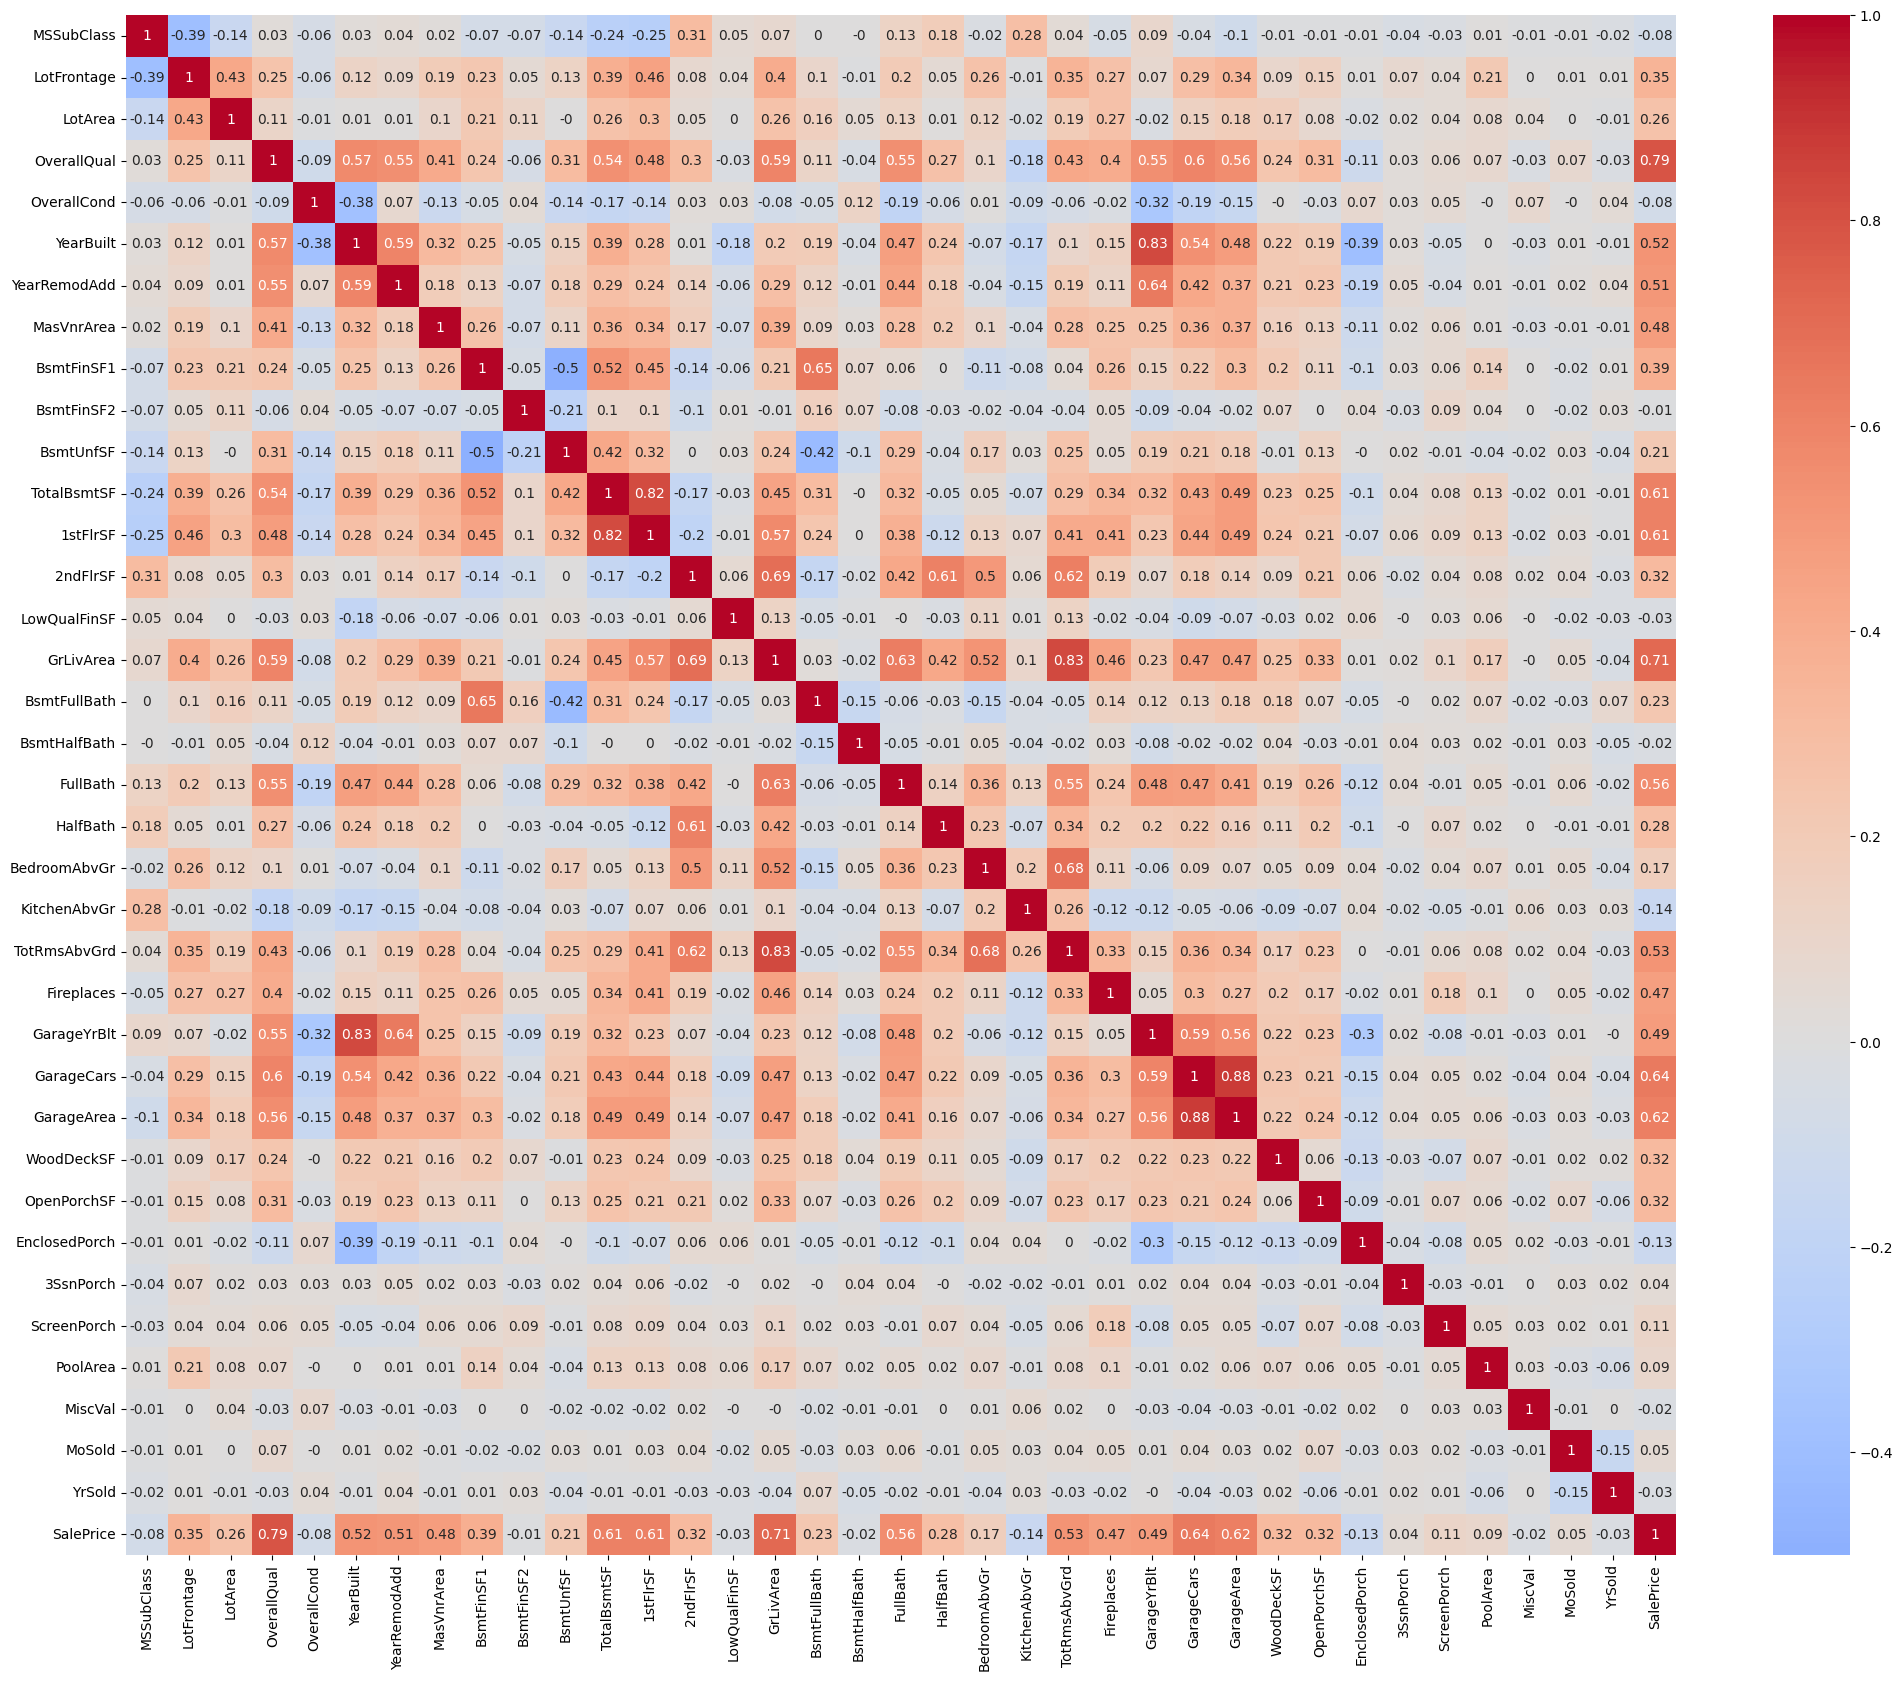

In [331]:
plt.subplots(figsize = (25,20))
sns.heatmap(round(numerical_features.corr(),2), cmap='coolwarm' , annot=True, center = 0)
plt.show()

Note: There're some variables with high correlation needed to be removed to avoid multicollinearity

## Handle missing data

Check for missing data in the dataset:

In [332]:
col_width = 15
# number of columns having missing values
col_count = 0
# calculate % missing values of each column
for col in data:
    missing_values = data[col].isnull().sum()
    if (missing_values / data.shape[0]) > 0:
      missing_values = round(missing_values*100/data.shape[0],2)
      print(f"Column {col.ljust(col_width)} : {missing_values}% missing values")
      col_count = col_count + 1

print(f'-------------------------------------------------')
print(f'Number of columns having missing values: {col_count} out of {data.shape[1]}')

Column LotFrontage     : 17.74% missing values
Column Alley           : 93.77% missing values
Column MasVnrType      : 59.73% missing values
Column MasVnrArea      : 0.55% missing values
Column BsmtQual        : 2.53% missing values
Column BsmtCond        : 2.53% missing values
Column BsmtExposure    : 2.6% missing values
Column BsmtFinType1    : 2.53% missing values
Column BsmtFinType2    : 2.6% missing values
Column Electrical      : 0.07% missing values
Column FireplaceQu     : 47.26% missing values
Column GarageType      : 5.55% missing values
Column GarageYrBlt     : 5.55% missing values
Column GarageFinish    : 5.55% missing values
Column GarageQual      : 5.55% missing values
Column GarageCond      : 5.55% missing values
Column PoolQC          : 99.52% missing values
Column Fence           : 80.75% missing values
Column MiscFeature     : 96.3% missing values
-------------------------------------------------
Number of columns having missing values: 19 out of 80


Check if it is there is any significances between null and not null before removing missing values:

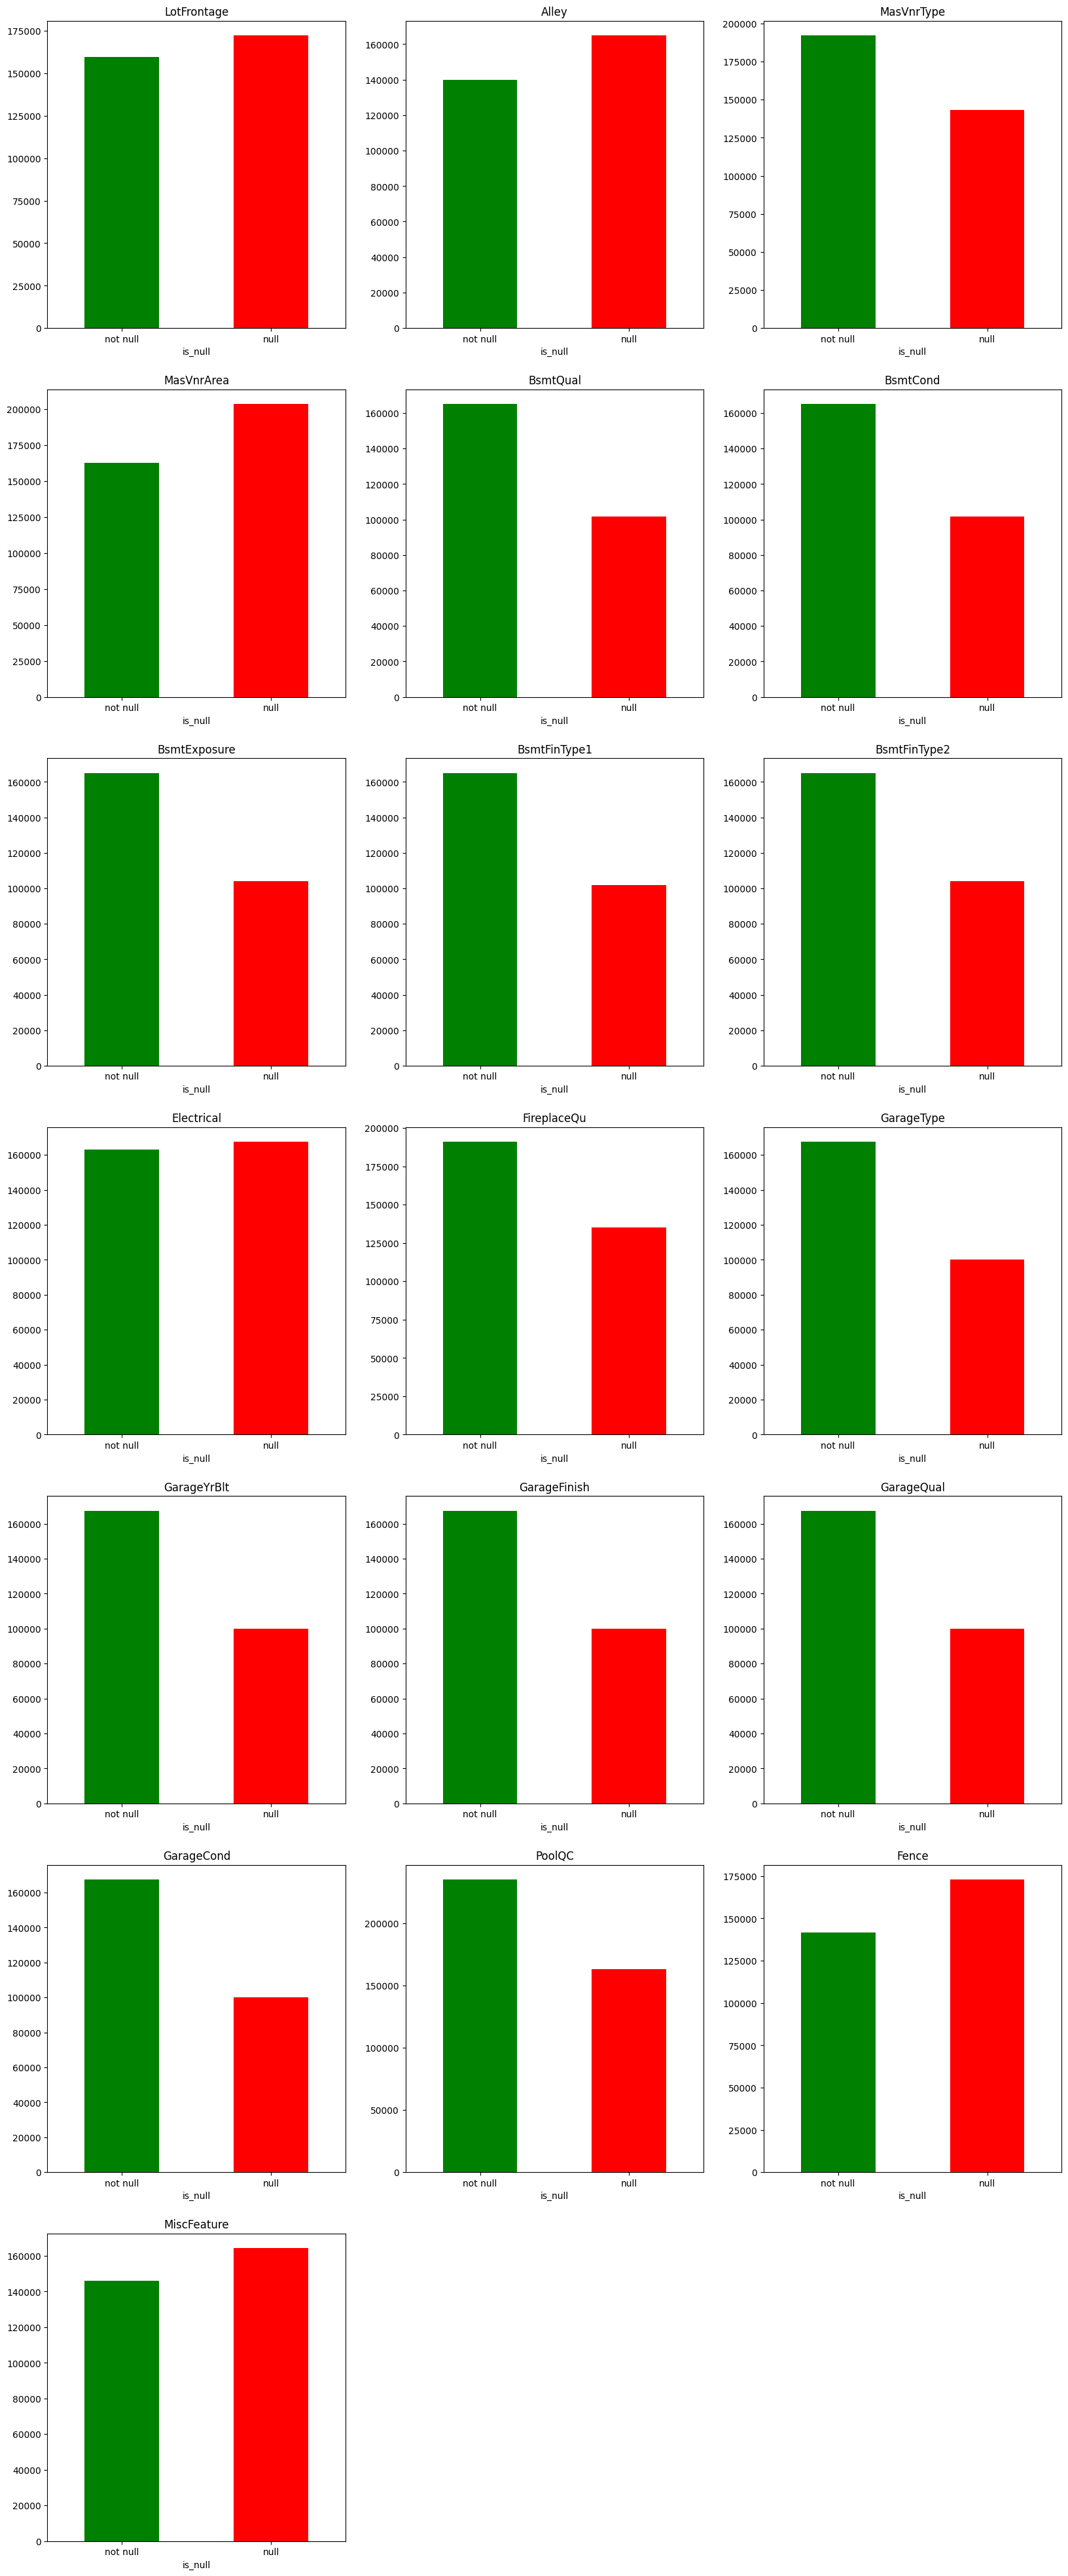

In [333]:
# make a list of 19 columns with missing values
col_with_null = []
for col in data.columns:
    if data[col].isnull().sum() > 0:
        col_with_null.append(col)
dt = data.copy()

# plot null vs, not null
fig,axs= plt.subplots(7,3,figsize=(20,50),squeeze=True)
for col,ax in zip(col_with_null,axs.flatten()):
    # Create a temporary column to indicate null values
    dt['is_null'] = dt[col].isnull()
    # calculate the mean of 'SalePrice' for each null and not null
    dt.groupby('is_null')['SalePrice'].median().plot.bar(color=list('gr'),rot=0,ax=ax,subplots=True)
    # Optionally, set the x-axis labels to 'null' and 'not null'
    ax.set_xticklabels(['not null', 'null'])
    ax.set_title(col)  # Set the title to the column name
axs[6,1].set_axis_off()
axs[6,2].set_axis_off()
plt.show()

=> there're significances between null and not null => replace missing values with others

Note: Split null with numeric and category for handling missing values

#### Category

In [334]:
col_width = 15
# number of columns having missing values
col_count = 0
# calculate % missing values of each column
for col in categorical_features:
    missing_values = data[col].isnull().sum()
    if (missing_values / data.shape[0]) > 0:
      missing_values = round(missing_values*100/data.shape[0],2)
      print(f"Column {col.ljust(col_width)} : {missing_values}% missing values")
      col_count = col_count + 1

print(f'-------------------------------------------------')
print(f'Number of columns having missing values: {col_count} out of {categorical_features.shape[1]}')

Column Alley           : 93.77% missing values
Column MasVnrType      : 59.73% missing values
Column BsmtQual        : 2.53% missing values
Column BsmtCond        : 2.53% missing values
Column BsmtExposure    : 2.6% missing values
Column BsmtFinType1    : 2.53% missing values
Column BsmtFinType2    : 2.6% missing values
Column Electrical      : 0.07% missing values
Column FireplaceQu     : 47.26% missing values
Column GarageType      : 5.55% missing values
Column GarageFinish    : 5.55% missing values
Column GarageQual      : 5.55% missing values
Column GarageCond      : 5.55% missing values
Column PoolQC          : 99.52% missing values
Column Fence           : 80.75% missing values
Column MiscFeature     : 96.3% missing values
-------------------------------------------------
Number of columns having missing values: 16 out of 43


In [335]:
for col in categorical_features:
  if col != 'Electrical':
    data[col] = data[col].fillna('NA')
  else:
    data[col] = data[col].fillna(data[col].mode()[0]) # no NA, fill with mode

In [336]:
col_width = 15
# number of columns having missing values
col_count = 0
# calculate % missing values of each column
for col in categorical_features:
    missing_values = data[col].isnull().sum()
    if (missing_values / data.shape[0]) > 0:
      missing_values = round(missing_values*100/data.shape[0],2)
      print(f"Column {col.ljust(col_width)} : {missing_values}% missing values")
      col_count = col_count + 1

print(f'-------------------------------------------------')
print(f'Number of columns having missing values: {col_count} out of {categorical_features.shape[1]}')

-------------------------------------------------
Number of columns having missing values: 0 out of 43


#### Numeric

In [337]:
col_width = 15
# number of columns having missing values
col_count = 0
# calculate % missing values of each column
for col in numerical_features:
    missing_values = data[col].isnull().sum()
    if (missing_values / data.shape[0]) > 0:
      missing_values = round(missing_values*100/data.shape[0],2)
      print(f"Column {col.ljust(col_width)} : {missing_values}% missing values")
      col_count = col_count + 1

print(f'-------------------------------------------------')
print(f'Number of columns having missing values: {col_count} out of {numerical_features.shape[1]}')

Column LotFrontage     : 17.74% missing values
Column MasVnrArea      : 0.55% missing values
Column GarageYrBlt     : 5.55% missing values
-------------------------------------------------
Number of columns having missing values: 3 out of 37


Note:
- If the house has no information about LotFrontage, we use average of LotFrontage of neighborhood to replace
- If the house has no MasVn, MasVnrArea is 0
- If the house has no garage, GarageYrBlt is 0

In [338]:
# Replace null values in LotFrontage with the median of the LotFrontage for each neighborhood
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# MasVnrArea, GarageYrBlt
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

In [339]:
col_width = 15
# number of columns having missing values
col_count = 0
# calculate % missing values of each column
for col in numerical_features:
    missing_values = data[col].isnull().sum()
    if (missing_values / data.shape[0]) > 0:
      missing_values = round(missing_values*100/data.shape[0],2)
      print(f"Column {col.ljust(col_width)} : {missing_values}% missing values")
      col_count = col_count + 1

print(f'-------------------------------------------------')
print(f'Number of columns having missing values: {col_count} out of {numerical_features.shape[1]}')

-------------------------------------------------
Number of columns having missing values: 0 out of 37


In [340]:
data.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC           0
Fence            0
MiscFeature      0
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
dtype: int64

## Remove redundant features

In [341]:
def redundant_feature(data):
    redundant = []
    for i in data.columns:
        counts = data[i].value_counts()
        count_max = counts.iloc[0]
        if count_max / len(data) * 100 > 99:
            redundant.append(i)
    redundant = list(redundant)
    return redundant

In [342]:
redundant_features = redundant_feature(data)
redundant_features

['Street', 'Utilities', 'PoolArea', 'PoolQC']

In [343]:
for col in ['Street', 'Utilities', 'Condition2', 'PoolArea', 'PoolQC']:
  if col in data.columns:
    print(f"{col} : {data[col].value_counts()}")

Street : Street
Pave    1454
Grvl       6
Name: count, dtype: int64
Utilities : Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64
Condition2 : Condition2
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: count, dtype: int64
PoolArea : PoolArea
0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: count, dtype: int64
PoolQC : PoolQC
NA    1453
Gd       3
Ex       2
Fa       2
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

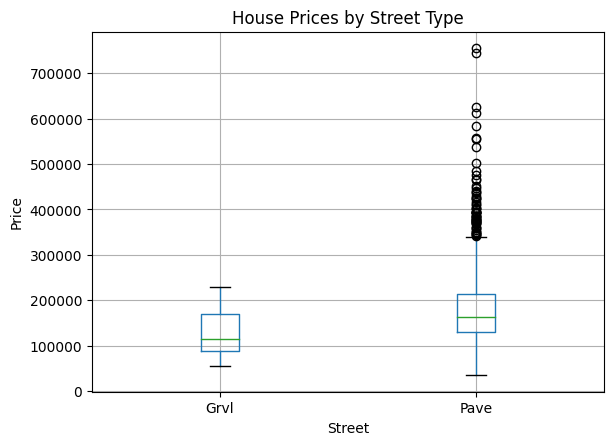

<Figure size 1000x600 with 0 Axes>

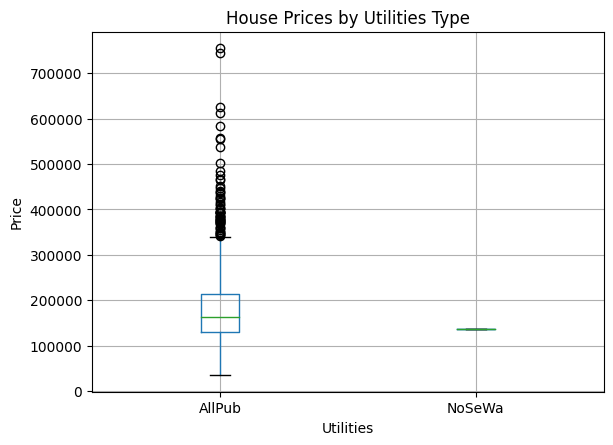

<Figure size 1000x600 with 0 Axes>

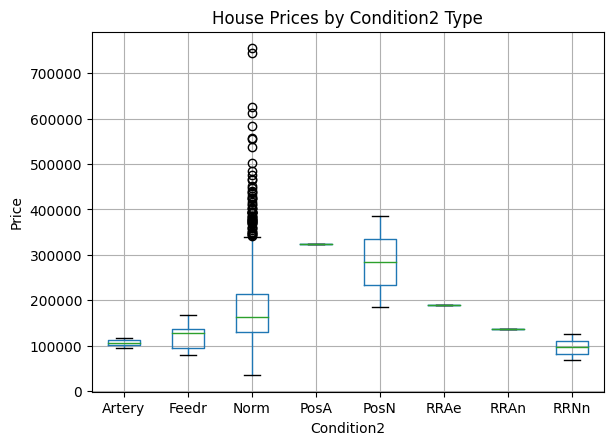

In [344]:
# Group data by Street type
Pave_prices = data[data['Street'] == 'Pave']['SalePrice']
Grvl_prices = data[data['Street'] == 'Grvl']['SalePrice']

# Group data by Utilities type
AllPub_prices = data[data['Utilities'] == 'AllPub']['SalePrice']
NoSeWa_prices = data[data['Utilities'] == 'NoSeWa']['SalePrice']

# Group data by Condition2 type
Norm_prices = data[data['Condition2'] == 'Norm']['SalePrice']
Feedr_prices = data[data['Condition2'] == 'Feedr']['SalePrice']
Artery_prices = data[data['Condition2'] == 'Artery']['SalePrice']
RRNn_prices = data[data['Condition2'] == 'RRNn']['SalePrice']
PosN_prices = data[data['Condition2'] == 'PosN']['SalePrice']
PosA_prices = data[data['Condition2'] == 'PosA']['SalePrice']
RRAn_prices = data[data['Condition2'] == 'RRAn']['SalePrice']

# Visualization using boxplot
for col in ['Street', 'Utilities', 'Condition2']:
    if col in data.columns:
        plt.figure(figsize=(10, 6))
        data.boxplot(column='SalePrice', by=col)
        plt.title(f"House Prices by {col} Type")
        plt.suptitle('')
        plt.xlabel(col)
        plt.ylabel('Price')
        plt.show()

Note: Significant difference in house prices between Street, Utilities, Condition2 type => not remove them out of dataset

In [345]:
data.drop(data[['PoolArea','PoolQC']],axis=1,inplace=True)

In [346]:
data.shape

(1460, 78)

## Handle outliers

In [347]:
data.shape

(1460, 78)

In [348]:
numerical_features = data.select_dtypes(include=np.number)
categorical_features = data.select_dtypes(include='object')

In [349]:
col_width = 15

# Count ouliers
def count_outliers(x):
    outlier_counts = {}
    for col in data[numerical_features.columns]:
        Q1 = x[col].quantile(0.25)
        Q3 = x[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Calculate the number of outliers
        outliers = x[(x[col] < lower_bound) | (x[col] > upper_bound)]
        count = len(outliers)

        # Only store columns that have outliers
        if count > 0:
            outlier_counts[col] = count

    return outlier_counts

# Print the columns that have outliers and the count
outlier_counts = count_outliers(data)
for col, count in outlier_counts.items():
    print(f"Column {col.ljust(col_width)}: {count} outliers")

Column LotFrontage    : 2 outliers
Column LotArea        : 4 outliers
Column BsmtFinSF1     : 1 outliers
Column TotalBsmtSF    : 1 outliers
Column 1stFlrSF       : 1 outliers
Column GarageYrBlt    : 81 outliers
Column 3SsnPorch      : 1 outliers
Column MiscVal        : 8 outliers


Note: There're about 100 outliers, but we do not handle them yet

In [350]:
data.shape

(1460, 78)

In [351]:
# # Removing outliers
# def drop_outliers(x):
#     list = []
#     for col in data[numerical_features.columns]:
#         Q1 = x[col].quantile(.25)
#         Q3 = x[col].quantile(.99)
#         IQR = Q3-Q1
#         x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))]
#     return x
# data = drop_outliers(data)
# data.shape

## Create new features

In [352]:
# create HouseAge, RemodeledAge
data['HouseAge'] = data['YrSold'] - data['YearBuilt']
data['RemodeledAge'] = data['YrSold'] - data['YearRemodAdd']

# create GarageAge
if 'GarageYrBlt' in data.columns and 'GarageYrBlt' != 0:
    data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']
else:
    data['GarageAge'] = 0

# create HasGarage
data['HasGarage'] = data['GarageYrBlt'].apply(lambda x: 1 if x != 0 else 0)

In [353]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [354]:
# drop columns
data.drop(['YearBuilt','GarageYrBlt','YearRemodAdd'], axis=1, inplace=True)

In [355]:
# create TitalBathrooms
data['TotalBathrooms'] = data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath'])

# create TotalPorchArea
data['TotalPorchArea'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']

# create TotalFinishedArea
data['TotalFinishedArea'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GrLivArea']

# create OverallScore
data['OverallScore'] = (data['OverallQual'] + data['OverallCond']) / 2

In [356]:
data['YrSold'] = data['YrSold'].astype('object')
data['MoSold'] = data['MoSold'].astype('object')

In [357]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   object 
 1   MSZoning           1460 non-null   object 
 2   LotFrontage        1460 non-null   float64
 3   LotArea            1460 non-null   int64  
 4   Street             1460 non-null   object 
 5   Alley              1460 non-null   object 
 6   LotShape           1460 non-null   object 
 7   LandContour        1460 non-null   object 
 8   Utilities          1460 non-null   object 
 9   LotConfig          1460 non-null   object 
 10  LandSlope          1460 non-null   object 
 11  Neighborhood       1460 non-null   object 
 12  Condition1         1460 non-null   object 
 13  Condition2         1460 non-null   object 
 14  BldgType           1460 non-null   object 
 15  HouseStyle         1460 non-null   object 
 16  OverallQual        1460 

## Create dummy variables

In [358]:
# # Creating Dummy Variables for Categorical Columns
# num_col=[]
# cat_col=[]
# for i in data.columns:
#     if data[i].dtypes != 'O':
#         num_col.append(i)
#     else:
#         cat_col.append(i)
# data_dummy= pd.get_dummies(data[cat_col])
# data=pd.concat([data,data_dummy],axis=1)
# data= data.drop(cat_col,axis=1)

In [359]:
categorical_col = data.select_dtypes(include=['object']).columns
numerical_col = data.select_dtypes(exclude=['object']).columns

In [360]:
print(categorical_col)
print(numerical_col)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence',
       'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',


In [361]:
# Create dummy variables without dropping columns
dummies = pd.get_dummies(data[categorical_col])

# Concatenate the original dataset with the dummy variables
data = pd.concat([data, dummies], axis=1)

# Optionally, drop the original categorical columns
data.drop(columns=categorical_col, inplace=True)

In [362]:
data.shape

(1460, 332)

In [363]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 332 entries, LotFrontage to SaleCondition_Partial
dtypes: bool(294), float64(5), int64(33)
memory usage: 852.7 KB


In [364]:
# bool_columns = data.select_dtypes(include=['bool']).columns
# data[bool_columns] = data[bool_columns].astype(int)

In [365]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 332 entries, LotFrontage to SaleCondition_Partial
dtypes: bool(294), float64(5), int64(33)
memory usage: 852.7 KB


## Check correlation

In [366]:
data.shape

(1460, 332)

In [367]:
# split dataset with features X and target y
X = data.drop(['SalePrice'], axis=1)
y = data['SalePrice']

In [368]:
# Get the correlation matrix
corr = X.corr()

# Set a threshold for high correlation (e.g., 0.6)
threshold = 0.6

# Filter for high correlations and remove self-correlations and duplicates
high_corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = high_corr_pairs.stack()  # Convert to a Series with pairs as index

# Filter pairs with absolute correlation greater than the threshold
high_corr_with_values = high_corr_pairs[abs(high_corr_pairs) > threshold]

# Print pairs and their correlation values
print("Columns with high correlation and their correlation values:\n", high_corr_with_values)

Columns with high correlation and their correlation values:
 OverallQual           GarageCars               0.600671
                      TotalFinishedArea        0.658838
                      OverallScore             0.756229
                      ExterQual_TA            -0.646247
MasVnrArea            MasVnrType_NA           -0.687737
BsmtFinSF1            BsmtFullBath             0.649212
                      BsmtFinType1_Unf        -0.628690
BsmtFinSF2            BsmtFinType2_Unf        -0.716235
BsmtUnfSF             BsmtFinType1_Unf         0.602707
TotalBsmtSF           1stFlrSF                 0.819530
                      TotalFinishedArea        0.703027
1stFlrSF              TotalFinishedArea        0.731139
2ndFlrSF              GrLivArea                0.687501
                      HalfBath                 0.609707
                      TotRmsAbvGrd             0.616423
                      MSSubClass_20           -0.602706
                      MSSubClass_60        

In [369]:
# Initialize a set to hold columns to drop
columns_to_drop = set()

# Loop over each highly correlated pair and add one column to the drop list
for col1, col2 in high_corr_with_values.index:
    # If neither column is already in the drop list, add one of them
    if col1 not in columns_to_drop and col2 not in columns_to_drop:
        columns_to_drop.add(col2)  # Arbitrarily choose col2 to drop

In [370]:
len(columns_to_drop)

88

In [371]:
# Drop the columns from the original DataFrame
X = X.drop(columns=columns_to_drop)

In [372]:
len(X.columns)

243

In [373]:
X.shape

(1460, 243)

Note: 88 columns with high correlation removed out of 332 columns

## Transformation

### target

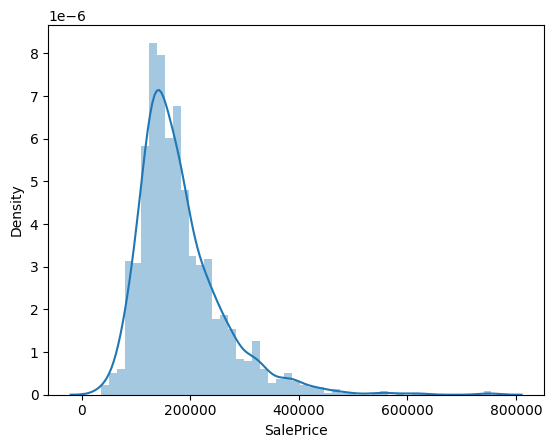

In [374]:
# current
sns.distplot(y)
plt.show()

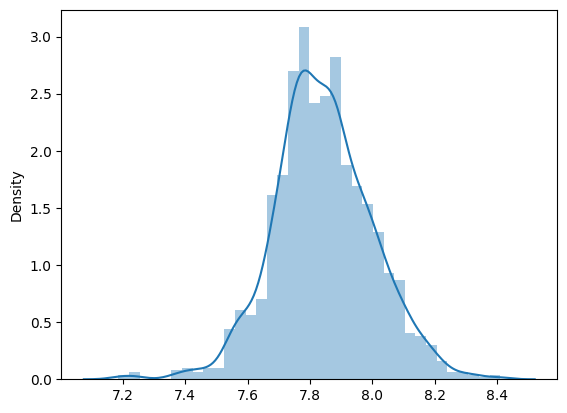

In [375]:
# transform target y to make y more gaussian
pt = PowerTransformer(method='box-cox', standardize=False)
y = pt.fit_transform(y.to_frame())
# after transforming
sns.distplot(y)
plt.show()

### features

In [376]:
# # numeric
# numerical_features = X.select_dtypes(include=np.number)
# # discrete
# discrete_features = [feature for feature in numerical_features if len(data[feature].unique())<25]
# print('Number of discrete numerical columns:', len(discrete_features))
# print(discrete_features)
# print('--------------------------------------------------------')

# # continous
# continous_features = [feature for feature in numerical_features if feature not in discrete_features]
# print('Number of continous numerical columns:', len(continous_features))
# print(continous_features)

In [377]:
# # plot histogram of continous features
# fig,axs= plt.subplots(5,4,figsize=(25,25))
# for i,ax in zip(continous_features,axs.flatten()):
#   X[i].hist(bins=20,ax=ax)
#   ax.set_title(i)

# # Hide any remaining empty subplots
# for i in range(len(continous_features), len(axs.flatten())):
#     fig.delaxes(axs.flatten()[i])

# plt.show()

Note: right-skewed

In [378]:
# # plot histogram after log transformation
# fig, axs = plt.subplots(5, 4, figsize=(25, 25))
# for i, ax in zip(continous_features, axs.flatten()):
#   X[i] = np.log1p(X[i])
#   X[i].hist(bins=20, ax=ax)
#   ax.set_title(i)

# # Hide any remaining empty subplots
# for i in range(len(continous_features), len(axs.flatten())):
#     fig.delaxes(axs.flatten()[i])

# plt.show()

## check outliers

In [379]:
# numeric
numerical_features = X.select_dtypes(include=np.number)

# continuos
continuous_features = [feature for feature in numerical_features if len(X[feature].unique()) > 25]

In [380]:
continuous_features

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'HouseAge',
 'RemodeledAge',
 'GarageAge']

In [381]:
y.shape

(1460, 1)

In [382]:
# Flatten y if it's a 2D array with a single column
if isinstance(y, np.ndarray) and y.ndim == 2 and y.shape[1] == 1:
    y = y.flatten()

# Convert y to a Pandas Series if it's still a NumPy array
if isinstance(y, np.ndarray):
    y = pd.Series(y, index=X.index)

# Count and collect outlier indices
def count_and_collect_outliers(x):
    outlier_counts = {}
    outlier_indices = set()

    for col in continuous_features:
        Q1 = x[col].quantile(0.25)
        Q3 = x[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Identify outliers and collect their indices
        outliers = x[(x[col] < lower_bound) | (x[col] > upper_bound)]
        count = len(outliers)

        if count > 0:
            outlier_counts[col] = count
            outlier_indices.update(outliers.index)

    return outlier_counts, outlier_indices

# Get outlier counts and indices
outlier_counts, outlier_indices = count_and_collect_outliers(X)

# Print columns with outliers and their counts
for col, count in outlier_counts.items():
    print(f"Column {col.ljust(col_width)}: {count} outliers")

Column LotFrontage    : 2 outliers
Column LotArea        : 4 outliers
Column BsmtFinSF1     : 1 outliers
Column TotalBsmtSF    : 1 outliers


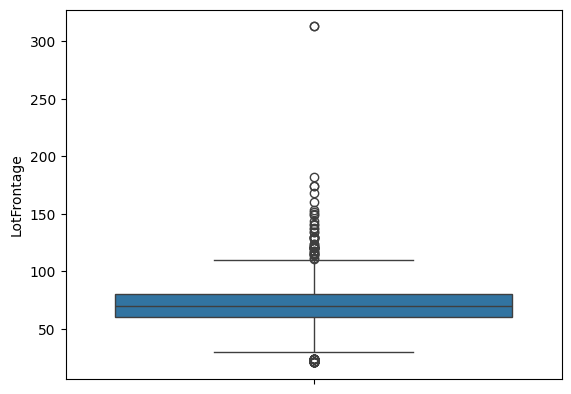

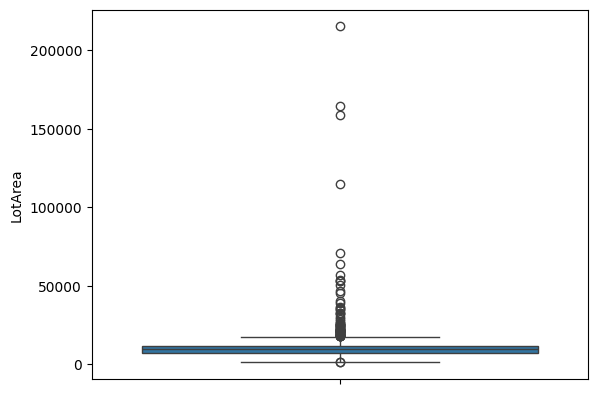

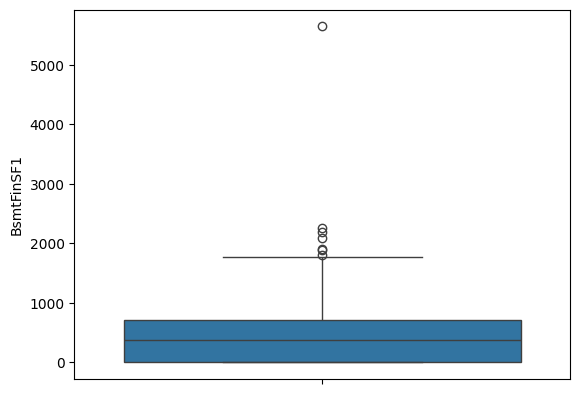

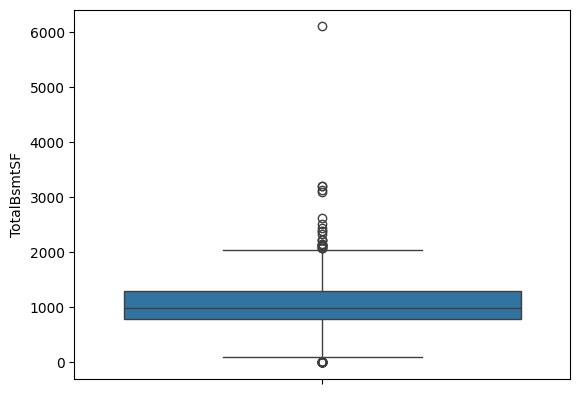

In [383]:
for i in ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF']:
  if i in X.columns:
    sns.boxplot(X[i])
    plt.show()

In [384]:
# Filter out the rows with outliers from both X and y
X = X.drop(index=outlier_indices)
y = y.loc[X.index]

In [385]:
print(X.shape)
print(y.shape)

(1454, 243)
(1454,)


## Scaler

In [386]:
print(X.shape)
print(y.shape)

(1454, 243)
(1454,)


In [387]:
# Chia dữ liệu thành tập train và test trước khi chuẩn hóa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [388]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1163, 243)
(1163,)
(291, 243)
(291,)


In [389]:
# Sử dụng StandardScaler để chuẩn hóa
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [390]:
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns
X_test = pd.DataFrame(X_test)
X_test.columns = X.columns

In [391]:
# # plot histogram of continous features
# fig,axs= plt.subplots(5,4,figsize=(25,25))
# for i,ax in zip(continous_features,axs.flatten()):
#   X_train[i].hist(bins=20,ax=ax)
#   ax.set_title(i)

# # Hide any remaining empty subplots
# for i in range(len(continous_features), len(axs.flatten())):
#     fig.delaxes(axs.flatten()[i])

# plt.show()

# VIF

In [392]:
# Chekcing the VIF
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
high_vif = vif[vif['VIF']>10]
high_vif

Features       VIF
122   Exterior1st_Wd Sdng       inf
221              MoSold_8       inf
219              MoSold_6       inf
218              MoSold_5       inf
217              MoSold_4       inf
216              MoSold_3       inf
215              MoSold_2       inf
214              MoSold_1       inf
185        Functional_Typ       inf
184        Functional_Sev       inf
183        Functional_Mod       inf
182       Functional_Min2       inf
181       Functional_Min1       inf
111   Exterior1st_BrkComm       inf
179       Functional_Maj1       inf
124   Exterior2nd_AsphShn       inf
123   Exterior1st_WdShing       inf
121   Exterior1st_VinylSd       inf
120    Exterior1st_Stucco       inf
119     Exterior1st_Stone       inf
118   Exterior1st_Plywood       inf
117   Exterior1st_MetalSd       inf
115   Exterior1st_HdBoard       inf
114   Exterior1st_CemntBd       inf
113    Exterior1st_CBlock       inf
112   Exterior1st_BrkFace       inf
109   Exterior1st_AsbShng       inf
220              MoSold_7       inf
180       Functional_Maj2       inf
110   Exterior1st_AsphShn       inf
223             MoSold_10       inf
229           YrSold_2009       inf
230           YrSold_2010       inf
8             TotalBsmtSF       inf
228           YrSold_2008       inf
226           YrSold_2006       inf
225             MoSold_12       inf
7               BsmtUnfSF       inf
224             MoSold_11       inf
227           YrSold_2007       inf
222              MoSold_9       inf
6              BsmtFinSF2       inf
5              BsmtFinSF1       inf
198      GarageFinish_Unf  11044.72
197      GarageFinish_RFn   9620.64
196      GarageFinish_Fin   8357.74
25              GarageAge   2560.85
153       BsmtExposure_No     35.33
150       BsmtExposure_Av     21.98
23               HouseAge     18.79
70     Neighborhood_NAmes     16.82
75   Neighborhood_OldTown     15.36
151       BsmtExposure_Gd     14.35
152       BsmtExposure_Mn     13.23
97          BldgType_1Fam     12.90

# Scenarios

## Scenario 1: Train model without removing high VIF columns

In [393]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

In [394]:
print(X_train_1.shape)
print(y_train.shape)
print(X_test_1.shape)
print(y_test.shape)

(1163, 243)
(1163,)
(291, 243)
(291,)


Fitting 11 folds for each of 34 candidates, totalling 374 fits


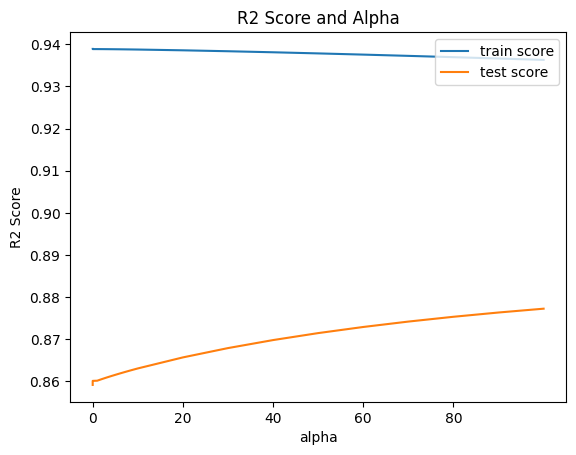

The optimum alpha is 100
The R² Score of the model on the test dataset for optimum alpha is 0.899909274182879
The MSE of the model on the test dataset for optimum alpha is 0.0025495324318258634
Cross-validation R² Score: 0.8831432036655467
Cross-validation MSE: 0.0019481586174215503


In [396]:
# using Ridge
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]}

# model
ridge = Ridge()

# using RFE to find top 200 variables
rfe = RFE(estimator=Ridge(), n_features_to_select=200)
rfe = rfe.fit(X_train_1,y_train)
col = X_train_1.columns[rfe.support_]
X_train_1_rfe = X_train_1[col]
X_test_1_rfe = X_test_1[col]

# Cross validation
folds = 11
model_cv = GridSearchCV(estimator=ridge, param_grid=params, scoring='r2',
                         cv=folds, return_train_score=True, verbose=1)
model_cv.fit(X_train_1_rfe, y_train)

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha'] <= 100]

# plotting mean test and train scoes with alpha
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.xticks(np.arange(0,100,20))
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is', alpha)

# Fit the final model with the optimum alpha
ridge_final = Ridge(alpha=alpha)
ridge_final.fit(X_train_1_rfe, y_train)

# Get coefficients and predictions
ridge_coef = ridge_final.coef_
y_test_pred = ridge_final.predict(X_test_1_rfe)

# Evaluate the model
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

print('The R² Score of the model on the test dataset for optimum alpha is', r2)
print('The MSE of the model on the test dataset for optimum alpha is', mse)

# Calculate and print CV score and MSE
cv_score = model_cv.best_score_
cv_mse = mean_squared_error(y_train, model_cv.predict(X_train_1_rfe))

print('Cross-validation R² Score:', cv_score)
print('Cross-validation MSE:', cv_mse)

In [ ]:
# using Lasso

## Scenario 2: Train model only removing high inf VIF columns

In [397]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

In [401]:
high_vif[high_vif['VIF']>50]

Features       VIF
122  Exterior1st_Wd Sdng       inf
221             MoSold_8       inf
219             MoSold_6       inf
218             MoSold_5       inf
217             MoSold_4       inf
216             MoSold_3       inf
215             MoSold_2       inf
214             MoSold_1       inf
185       Functional_Typ       inf
184       Functional_Sev       inf
183       Functional_Mod       inf
182      Functional_Min2       inf
181      Functional_Min1       inf
111  Exterior1st_BrkComm       inf
179      Functional_Maj1       inf
124  Exterior2nd_AsphShn       inf
123  Exterior1st_WdShing       inf
121  Exterior1st_VinylSd       inf
120   Exterior1st_Stucco       inf
119    Exterior1st_Stone       inf
118  Exterior1st_Plywood       inf
117  Exterior1st_MetalSd       inf
115  Exterior1st_HdBoard       inf
114  Exterior1st_CemntBd       inf
113   Exterior1st_CBlock       inf
112  Exterior1st_BrkFace       inf
109  Exterior1st_AsbShng       inf
220             MoSold_7       inf
180      Functional_Maj2       inf
110  Exterior1st_AsphShn       inf
223            MoSold_10       inf
229          YrSold_2009       inf
230          YrSold_2010       inf
8            TotalBsmtSF       inf
228          YrSold_2008       inf
226          YrSold_2006       inf
225            MoSold_12       inf
7              BsmtUnfSF       inf
224            MoSold_11       inf
227          YrSold_2007       inf
222             MoSold_9       inf
6             BsmtFinSF2       inf
5             BsmtFinSF1       inf
198     GarageFinish_Unf  11044.72
197     GarageFinish_RFn   9620.64
196     GarageFinish_Fin   8357.74
25             GarageAge   2560.85

In [402]:
# Dropping cols with high VIF
X_train_2 = X_train_2.drop(high_vif[high_vif['VIF']>50].Features,axis=1)
X_test_2 = X_test_2.drop(high_vif[high_vif['VIF']>50].Features,axis=1)

In [403]:
X2 = X.copy()
X2 = X2.drop(high_vif[high_vif['VIF']>50].Features,axis=1)

In [404]:
print(X_train_2.shape)
print(y_train.shape)
print(X_test_2.shape)
print(y_test.shape)

(1163, 196)
(1163,)
(291, 196)
(291,)


Fitting 11 folds for each of 34 candidates, totalling 374 fits


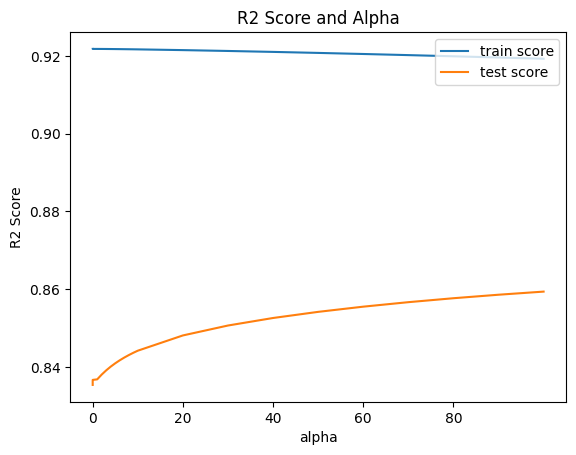

The optimum alpha is 100
The R² Score of the model on the test dataset for optimum alpha is 0.8760903933536281
The MSE of the model on the test dataset for optimum alpha is 0.003156252072114283
Cross-validation R² Score: 0.8648554020557261
Cross-validation MSE: 0.0023719541130238736


In [405]:
# using Ridge
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]}

# model
ridge = Ridge()

# using RFE to find top 200 variables
rfe = RFE(estimator=Ridge(), n_features_to_select=200)
rfe = rfe.fit(X_train_2,y_train)
col = X_train_2.columns[rfe.support_]
X_train_2_rfe = X_train_2[col]
X_test_2_rfe = X_test_2[col]

# Cross validation
folds = 11
model_cv = GridSearchCV(estimator=ridge, param_grid=params, scoring='r2',
                         cv=folds, return_train_score=True, verbose=1)
model_cv.fit(X_train_2_rfe, y_train)

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha'] <= 100]

# plotting mean test and train scoes with alpha
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score and Alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.xticks(np.arange(0,100,20))
plt.show()

alpha = cv_results['param_alpha'].loc[cv_results['mean_test_score'].idxmax()]
print('The optimum alpha is', alpha)

# Fit the final model with the optimum alpha
ridge_final = Ridge(alpha=alpha)
ridge_final.fit(X_train_2_rfe, y_train)

# Get coefficients and predictions
ridge_coef = ridge_final.coef_
y_test_pred = ridge_final.predict(X_test_2_rfe)

# Evaluate the model
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

print('The R² Score of the model on the test dataset for optimum alpha is', r2)
print('The MSE of the model on the test dataset for optimum alpha is', mse)

# Calculate and print CV score and MSE
cv_score = model_cv.best_score_
cv_mse = mean_squared_error(y_train, model_cv.predict(X_train_2_rfe))

print('Cross-validation R² Score:', cv_score)
print('Cross-validation MSE:', cv_mse)

In [ ]:
# using Lasso

## Scenario 3: Train model with removing all high VIF (> 10) columns

In [406]:
X_train_3 = X_train.copy()
X_test_3 = X_test.copy()

In [407]:
# Dropping cols with high VIF
X_train_3 = X_train_3.drop(high_vif.Features,axis=1)
X_test_3 = X_test_3.drop(high_vif.Features,axis=1)

In [408]:
X3 = X.copy()
X3 = X3.drop(high_vif.Features,axis=1)

In [409]:
print(X_train_3.shape)
print(y_train.shape)
print(X_test_3.shape)
print(y_test.shape)

(1163, 188)
(1163,)
(291, 188)
(291,)


### ridge

Fitting 11 folds for each of 34 candidates, totalling 374 fits


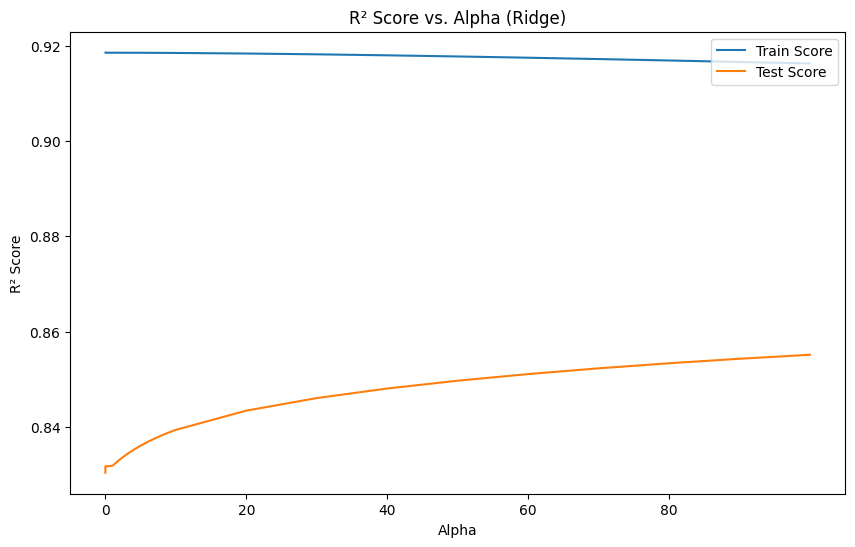

Optimal Alpha: 100
R² Score on test set with optimal alpha: 0.8736782418694475
MSE on test set with optimal alpha: 0.0032176949119896965
Cross-validation R² Score: 0.8613084315927999
Cross-validation MSE: 0.0024538159171469745


In [446]:
# Define list of alphas to tune
ridge_params = {'alpha': [
    0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
    4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500
]}

# Initialize Ridge model
ridge_model = Ridge()

# Feature selection with RFE to select top 200 features
rfe_selector = RFE(estimator=ridge_model, n_features_to_select=200)
rfe_selector = rfe_selector.fit(X_train_3, y_train)

# Select only the top features for training and testing sets
selected_features = X_train_3.columns[rfe_selector.support_]
X_train_selected = X_train_3[selected_features]
X_test_selected = X_test_3[selected_features]

# Set up cross-validation with Ridge model
fold_count = 11
ridge_cv_model = GridSearchCV(
    estimator=ridge_model, param_grid=ridge_params, scoring='r2',
    cv=fold_count, return_train_score=True, verbose=1
)
ridge_cv_model.fit(X_train_selected, y_train)

# Store cross-validation results
cv_results_ridge = pd.DataFrame(ridge_cv_model.cv_results_)
cv_results_ridge = cv_results_ridge[cv_results_ridge['param_alpha'] <= 100]
cv_results_ridge['param_alpha'] = cv_results_ridge['param_alpha'].astype('int32')

# Plot R² Score vs. Alpha for both train and test sets
plt.figure(figsize=(10, 6))
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_train_score'], label='Train Score')
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_test_score'], label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title("R² Score vs. Alpha (Ridge)")
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 100, 20))
plt.show()

# Extract best alpha and retrain Ridge model
best_alpha = cv_results_ridge['param_alpha'].loc[cv_results_ridge['mean_test_score'].idxmax()]
print('Optimal Alpha:', best_alpha)

ridge_final_model = Ridge(alpha=best_alpha)
ridge_final_model.fit(X_train_selected, y_train)

# Get predictions on test set
ridge_coef = ridge_final.coef_
y_pred_test = ridge_final_model.predict(X_test_selected)

# Calculate R² and MSE on the test set
test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)

print('R² Score on test set with optimal alpha:', test_r2)
print('MSE on test set with optimal alpha:', test_mse)

# Get cross-validation R² score and MSE on train set
ridge_cv_best_score = ridge_cv_model.best_score_
ridge_cv_train_mse = mean_squared_error(y_train, ridge_cv_model.predict(X_train_selected))

print('Cross-validation R² Score:', ridge_cv_best_score)
print('Cross-validation MSE:', ridge_cv_train_mse)

In [431]:
#Displaing the co-efficients of the model
ridge_coeff = pd.DataFrame(np.atleast_2d(ridge_coef),columns=X_train_selected.columns)
ridge_coeff = ridge_coeff.T
ridge_coeff.rename(columns={0: 'Ridge Co-Efficient'},inplace=True)
ridge_coeff.sort_values(by=['Ridge Co-Efficient'], ascending=False,inplace=True)
ridge_coeff.head(20)

Ridge Co-Efficient
OverallQual                     0.028981
GarageArea                      0.021225
BsmtFinType1_GLQ                0.016124
FullBath                        0.013391
Fireplaces                      0.012482
BedroomAbvGr                    0.011500
LotArea                         0.011157
BsmtQual_Ex                     0.010650
Neighborhood_Crawfor            0.010410
KitchenQual_Ex                  0.010054
OverallCond                     0.009836
Neighborhood_StoneBr            0.009591
Neighborhood_NoRidge            0.007994
2ndFlrSF                        0.007953
HeatingQC_Ex                    0.007937
LotFrontage                     0.007781
GarageType_Attchd               0.007516
BsmtFinType1_ALQ                0.007444
BsmtQual_Gd                     0.007264
WoodDeckSF                      0.007098

### lasso

Fitting 11 folds for each of 11 candidates, totalling 121 fits


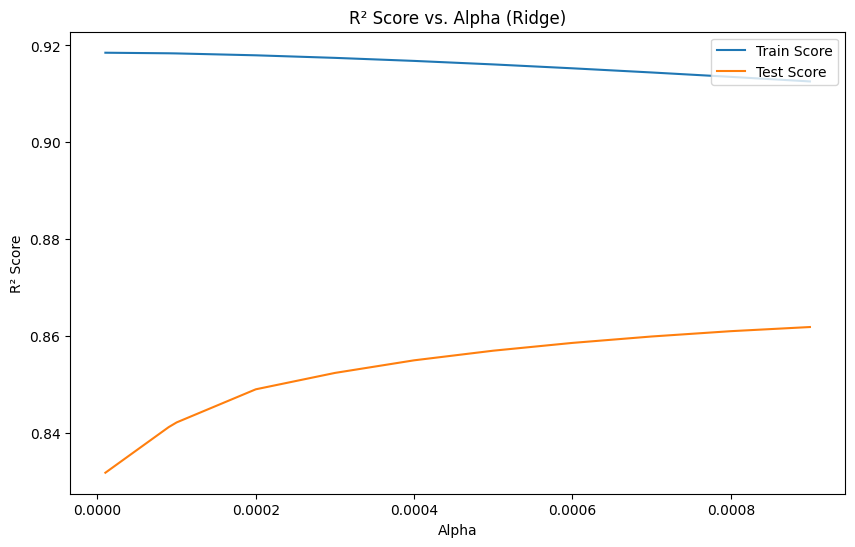

Optimal Alpha: 0.0009
R² Score on test set with optimal alpha: 0.8800320511074025
MSE on test set with optimal alpha: 0.0030558493205469985
Cross-validation R² Score: 0.8618918128183144
Cross-validation MSE: 0.002228350056056219


In [443]:
# Define list of alphas to tune
lasso_params = {'alpha': [0.00001, 0.00009, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                    0.0006, 0.0007, 0.0008, 0.0009]}

# Initialize Lasso model
lasso_model = Lasso(random_state=100)

# Set up cross-validation with Ridge model
fold_count = 11
lasso_cv_model = GridSearchCV(
    estimator=lasso_model, param_grid=lasso_params, scoring='r2',
    cv=fold_count, return_train_score=True, verbose=1
)
lasso_cv_model.fit(X_train_selected, y_train)

# Store cross-validation results
cv_results_lasso = pd.DataFrame(lasso_cv_model.cv_results_)

# Plot R² Score vs. Alpha for both train and test sets
plt.figure(figsize=(10, 6))
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_train_score'], label='Train Score')
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_test_score'], label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title("R² Score vs. Alpha (Ridge)")
plt.legend(loc='upper right')
plt.show()

# Extract best alpha and retrain Ridge model
best_alpha = cv_results_lasso['param_alpha'].loc[cv_results_lasso['mean_test_score'].idxmax()]
print('Optimal Alpha:', best_alpha)

lasso_final_model = Lasso(alpha=best_alpha)
lasso_final_model.fit(X_train_selected, y_train)

# Get coefficients and predictions
lasso_coef = lasso_final_model.coef_
y_pred_test = lasso_final_model.predict(X_test_selected)

# Calculate R² and MSE on the test set
test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)

print('R² Score on test set with optimal alpha:', test_r2)
print('MSE on test set with optimal alpha:', test_mse)

# Get cross-validation R² score and MSE on train set
lasso_cv_best_score = lasso_cv_model.best_score_
lasso_cv_train_mse = mean_squared_error(y_train, lasso_cv_model.predict(X_train_selected))

print('Cross-validation R² Score:', lasso_cv_best_score)
print('Cross-validation MSE:', lasso_cv_train_mse)

In [435]:
#Displaing the co-efficients of the model
lasso_coef = pd.DataFrame(np.atleast_2d(lasso_coef),columns=X_train_selected.columns)
lasso_coef = lasso_coef.T
lasso_coef.rename(columns={0: 'Lasso Co-Efficient'},inplace=True)
lasso_coef.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
lasso_coef.head(20)

Lasso Co-Efficient
OverallQual                     0.039039
GarageArea                      0.023409
BsmtFinType1_GLQ                0.015765
Fireplaces                      0.014836
FullBath                        0.013823
BedroomAbvGr                    0.011831
LotArea                         0.011686
BsmtQual_Ex                     0.010916
Neighborhood_Crawfor            0.010596
OverallCond                     0.009477
KitchenQual_Ex                  0.009309
2ndFlrSF                        0.008398
Neighborhood_StoneBr            0.008106
LotFrontage                     0.007718
HeatingQC_Ex                    0.007166
BsmtFinType1_ALQ                0.007092
BsmtQual_Gd                     0.007006
Neighborhood_NoRidge            0.006995
WoodDeckSF                      0.006478
GarageType_Attchd               0.005433

### elastic net

Fitting 11 folds for each of 55 candidates, totalling 605 fits


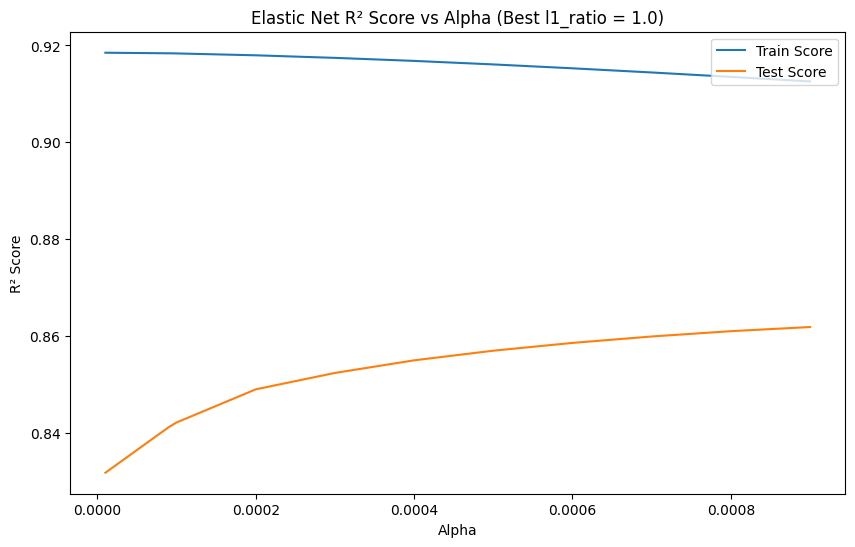

Optimal Alpha: 0.0009
Optimal l1_ratio: 1.0
Elastic Net R² Score on test set with optimal parameters: 0.8800320511074025
Elastic Net MSE on test set with optimal parameters: 0.0030558493205469985
Elastic Net Cross-validation R² Score: 0.8618918128183144
Elastic Net Cross-validation MSE: 0.002228350056056219


In [436]:
# Define parameter grid for Elastic Net
elastic_net_params = {
    'alpha': [0.00001, 0.00009, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
              0.0006, 0.0007, 0.0008, 0.0009],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  # Controls mix between Lasso and Ridge
}

# Initialize Elastic Net model
elastic_net_model = ElasticNet(random_state=100)

# Set up cross-validation for Elastic Net model
elastic_net_folds = 11
elastic_net_grid_search_cv = GridSearchCV(
    estimator=elastic_net_model, param_grid=elastic_net_params, scoring='r2',
    cv=elastic_net_folds, return_train_score=True, verbose=1
)
elastic_net_grid_search_cv.fit(X_train_selected, y_train)

# Convert cross-validation results to DataFrame
elastic_net_cv_results_df = pd.DataFrame(elastic_net_grid_search_cv.cv_results_)

# Plot R² Score vs. Alpha for the best l1_ratio
best_l1_ratio = elastic_net_grid_search_cv.best_params_['l1_ratio']
elastic_net_cv_results_best_l1 = elastic_net_cv_results_df[elastic_net_cv_results_df['param_l1_ratio'] == best_l1_ratio]

plt.figure(figsize=(10, 6))
plt.plot(elastic_net_cv_results_best_l1['param_alpha'], elastic_net_cv_results_best_l1['mean_train_score'], label='Train Score')
plt.plot(elastic_net_cv_results_best_l1['param_alpha'], elastic_net_cv_results_best_l1['mean_test_score'], label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title(f"Elastic Net R² Score vs Alpha (Best l1_ratio = {best_l1_ratio})")
plt.legend(loc='upper right')
plt.show()

# Extract best parameters and retrain Elastic Net model
optimal_alpha = elastic_net_grid_search_cv.best_params_['alpha']
optimal_l1_ratio = elastic_net_grid_search_cv.best_params_['l1_ratio']
print(f'Optimal Alpha: {optimal_alpha}')
print(f'Optimal l1_ratio: {optimal_l1_ratio}')

elastic_net_final_model = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio, random_state=100)
elastic_net_final_model.fit(X_train_selected, y_train)

# Get coefficients and predictions
elastic_net_coef = elastic_net_final_model.coef_
elastic_net_y_test_pred = elastic_net_final_model.predict(X_test_selected)

# Evaluate the model
elastic_net_test_r2 = r2_score(y_test, elastic_net_y_test_pred)
elastic_net_test_mse = mean_squared_error(y_test, elastic_net_y_test_pred)

print('Elastic Net R² Score on test set with optimal parameters:', elastic_net_test_r2)
print('Elastic Net MSE on test set with optimal parameters:', elastic_net_test_mse)

# Get cross-validation R² score and MSE on train set
elastic_net_cv_best_score = elastic_net_grid_search_cv.best_score_
elastic_net_cv_train_mse = mean_squared_error(y_train, elastic_net_grid_search_cv.predict(X_train_selected))

print('Elastic Net Cross-validation R² Score:', elastic_net_cv_best_score)
print('Elastic Net Cross-validation MSE:', elastic_net_cv_train_mse)

In [437]:
#Displaing the co-efficients of the model
elastic_net_coef = pd.DataFrame(np.atleast_2d(elastic_net_coef),columns=X_train_selected.columns)
elastic_net_coef = elastic_net_coef.T
elastic_net_coef.rename(columns={0: 'Elastic Net Co-Efficient'},inplace=True)
elastic_net_coef.sort_values(by=['Elastic Net Co-Efficient'], ascending=False,inplace=True)
elastic_net_coef.head(20)

Elastic Net Co-Efficient
OverallQual                           0.039039
GarageArea                            0.023409
BsmtFinType1_GLQ                      0.015765
Fireplaces                            0.014836
FullBath                              0.013823
BedroomAbvGr                          0.011831
LotArea                               0.011686
BsmtQual_Ex                           0.010916
Neighborhood_Crawfor                  0.010596
OverallCond                           0.009477
KitchenQual_Ex                        0.009309
2ndFlrSF                              0.008398
Neighborhood_StoneBr                  0.008106
LotFrontage                           0.007718
HeatingQC_Ex                          0.007166
BsmtFinType1_ALQ                      0.007092
BsmtQual_Gd                           0.007006
Neighborhood_NoRidge                  0.006995
WoodDeckSF                            0.006478
GarageType_Attchd                     0.005433

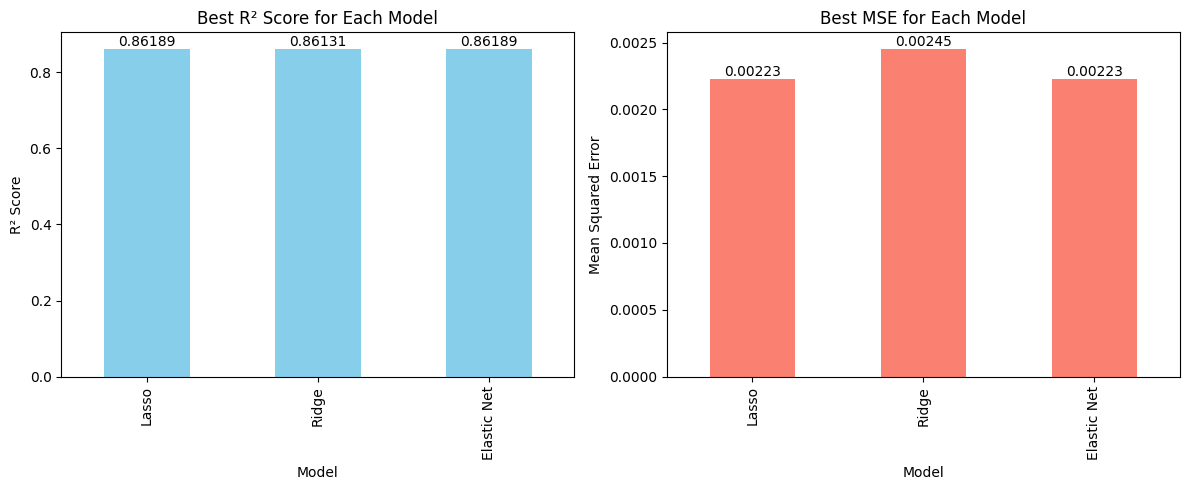

In [447]:
# Bar Chart: Best R² and MSE for Each Model with Data Labels to 5 Decimal Places
best_scores = {
    'Model': ['Lasso', 'Ridge', 'Elastic Net'],
    'Best R²': [lasso_cv_best_score, ridge_cv_best_score, elastic_net_cv_best_score],
    'Best MSE': [lasso_cv_train_mse, ridge_cv_train_mse, elastic_net_cv_train_mse]
}
best_scores_df = pd.DataFrame(best_scores)

# Plot Best R² and MSE
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot R² Score with data labels
bar_r2 = best_scores_df.plot(x='Model', y='Best R²', kind='bar', ax=ax[0], color='skyblue', legend=False)
ax[0].set_title('Best R² Score for Each Model')
ax[0].set_ylabel('R² Score')
for bar in ax[0].patches:
    ax[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
               f'{bar.get_height():.5f}', ha='center', va='bottom')  # Display 5 decimal places

# Plot MSE with data labels
bar_mse = best_scores_df.plot(x='Model', y='Best MSE', kind='bar', ax=ax[1], color='salmon', legend=False)
ax[1].set_title('Best MSE for Each Model')
ax[1].set_ylabel('Mean Squared Error')
for bar in ax[1].patches:
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
               f'{bar.get_height():.5f}', ha='center', va='bottom')  # Display 5 decimal places

plt.tight_layout()
plt.show()

# Save three models

In [438]:
joblib.dump(ridge_final_model, 'ridge_final.pkl')
joblib.dump(lasso_final_model, 'lasso_final.pkl')
joblib.dump(elastic_net_final_model, 'elastic_net_final.pkl')

['elastic_net_final.pkl']

# PCA

In [ ]:
# Áp dụng PCA với số lượng thành phần lớn để tính toán phương sai tích lũy
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)

PCA(n_components=195)

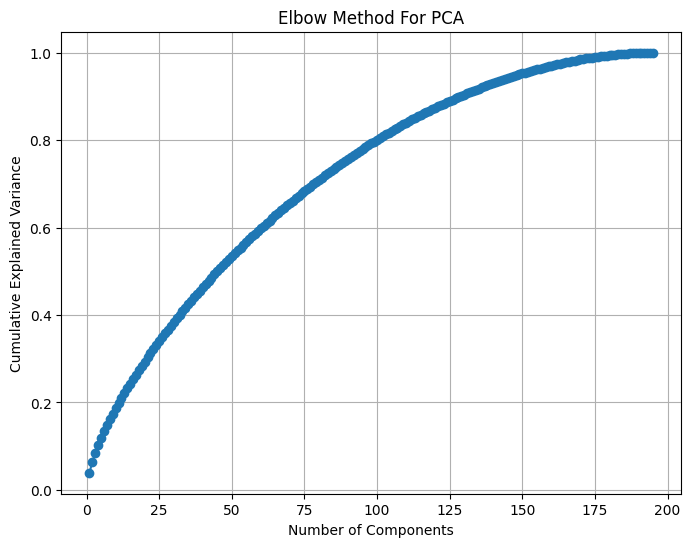

In [ ]:
# Vẽ biểu đồ Elbow
plt.figure(figsize=(8, 6))
plt.plot(range(1, X_train.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method For PCA')
plt.grid(True)
plt.show()

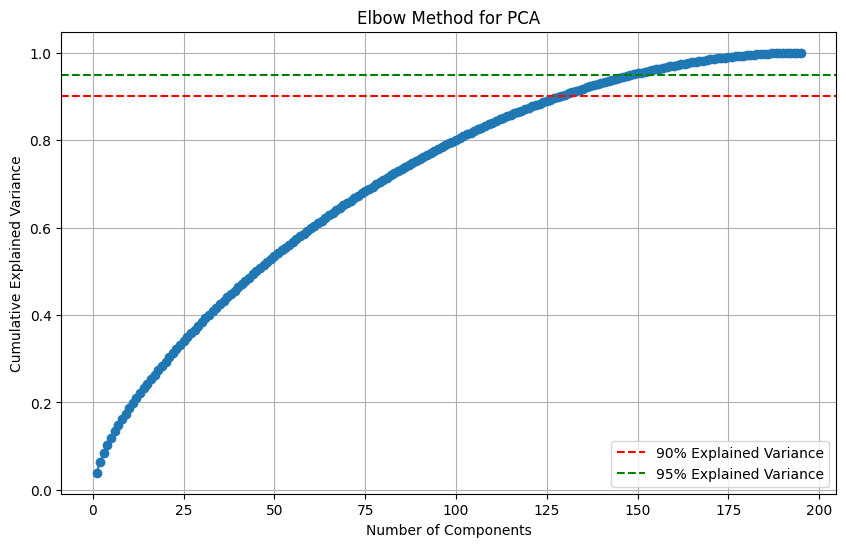

In [ ]:
# Get the explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Explained Variance')
plt.title('Elbow Method for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# Find the number of components for 90% and 95% variance
num_components_90 = np.argmax(explained_variance >= 0.90) + 1
num_components_95 = np.argmax(explained_variance >= 0.95) + 1

print(f"Number of components for 90% variance: {num_components_90}")
print(f"Number of components for 95% variance: {num_components_95}")

Number of components for 90% variance: 129
Number of components for 95% variance: 149


In [ ]:
# Apply PCA
pca = PCA(n_components=149)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)